# Visualize Simulated Boycott Results

In [273]:
from collections import defaultdict
import json

In [274]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="dark")
from scipy import stats

from scipy.interpolate import interp1d

NUM_USERS = 6040

First things first: let's load our master data file (a single, aggregated csv)
and take a glance at the data.

In [275]:
df = pd.read_csv('all_results.csv', dtype={'indices': str})
df.sample(5)

,Unnamed: 0,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0.1,fit_time_all,fit_time_all-like-boycott,fit_time_boycott,...,rmse_all-like-boycott,rmse_boycott,rmse_like-boycott,rmse_non-boycott,test_times_all,test_times_all-like-boycott,test_times_boycott,test_times_like-boycott,test_times_non-boycott,type
29403,495,60 user sample,SVD,501-to-750,1.0,1.0,0247_SVD,47.283405,47.283405,47.283405,...,0.937701,0.937701,NaN,0.874183,16.426429,30.376564,30.353099,NaN,29.362162,sample_users
32204,88,users from state US_OK excluded,KNNBaseline_item_msd,NaN,1.0,1.0,0044_KNNBaseline_item_msd,25.610055,25.610055,25.610055,...,0.983448,0.983448,NaN,0.885037,173.747027,333.672093,333.627225,NaN,331.476810,state
11472,64,302 user sample,KNNBaseline_item_msd,751-to-1000,1.0,1.0,0032_KNNBaseline_item_msd,24.893939,24.893939,24.893939,...,0.996673,0.996673,NaN,0.884705,117.054096,230.099843,229.891400,NaN,228.123397,sample_users
31509,101,6 user sample,SVD,751-to-1000,1.0,1.0,0050_SVD,78.739808,78.739808,78.739808,...,1.105624,1.105624,NaN,0.873756,32.878389,57.060387,57.055918,NaN,55.258522,sample_users
14163,255,3624 user sample,SVD,1-to-250,1.0,1.0,0127_SVD,33.652253,33.652253,33.652253,...,0.990512,0.990512,NaN,0.895549,40.507566,115.116741,86.632228,NaN,61.761936,sample_users


Let's apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.

In [276]:
df = df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in df.num_users])

Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [277]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
metrics = [
    'rmse',
    'ndcg10',
    #'prec10t4',
    'ndcgfull',
]
organized_experiments = [
    'gender', 'age', 'state',
    'occupation', 'power', 'genre'
]
algo_names = ['KNNBaseline_item_msd', 'SVD']
standard_algo_names = ['KNNBaseline_item_msd', 'SVD', 'GlobalMean', 'MovieMean', 'GuessThree']
standard_results = {}
algo_to_metric_vs_global_mean = defaultdict(dict)
algo_to_metric_vs_movie_mean = defaultdict(dict)
algo_to_metric_vs_guess_three = defaultdict(dict)

for algo_name in standard_algo_names:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        'ml-1m', algo_name)
    with open(filename_ratingcv_standards, 'r') as f:
        standard_results[algo_name] = json.load(f)
for main_algo_name in algo_names:
    for metric in metrics:
        goodval = standard_results[main_algo_name][metric]
        gmean = standard_results['GlobalMean'][metric]
        mmean = standard_results['MovieMean'][metric]
        guess_three = standard_results['GuessThree'][metric]
        algo_to_metric_vs_global_mean[main_algo_name][metric] = (gmean - goodval) / goodval * 100
        algo_to_metric_vs_movie_mean[main_algo_name][metric] = (mmean - goodval) / goodval * 100
        algo_to_metric_vs_guess_three[main_algo_name][metric] = (guess_three - goodval) / goodval * 100
print(algo_to_metric_vs_global_mean)
print(algo_to_metric_vs_movie_mean)
print(algo_to_metric_vs_guess_three)

defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 26.191851778027537, 'ndcg10': -25.055444802476618, 'ndcgfull': -8.83614409772126}, 'SVD': {'rmse': 27.862286090082577, 'ndcg10': -25.249001053815856, 'ndcgfull': -8.958942358562838}})
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 10.632081538342637, 'ndcg10': -2.248843148449569, 'ndcgfull': -0.6264745815763064}, 'SVD': {'rmse': 12.09654713110365, 'ndcg10': -2.5013010813093173, 'ndcgfull': -0.7603313165103744}})
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 42.26819253699301, 'ndcg10': -25.071561610898957, 'ndcgfull': -8.844290663647236}, 'SVD': {'rmse': 44.151433546451166, 'ndcg10': -25.26507623801328, 'ndcgfull': -8.967077951015638}})


In [278]:
algo_to_metric_to_slope = defaultdict(dict)
algo_to_metric_to_intercept = defaultdict(dict)
algo_to_metric_to_average_boycott = defaultdict(dict)


In [279]:
samples_df = df[df['type'] == 'sample_users']
print(samples_df[['num_users', 'num_users_boycotting']].sample(5))
org_df = df[df['type'].isin(organized_experiments)]

       num_users  num_users_boycotting
28337       5980                    60
21584       1208                  4832
24455         60                  5980
7814        3624                  2416
22157        604                  5436


In [280]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('US_', '')
    .replace('state', '')
    .strip()
    for x in list(org_df.name)
]

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


First, let's see how well the # of ratings correlates with error
This will be an important piece of context for analyzing the experiments.

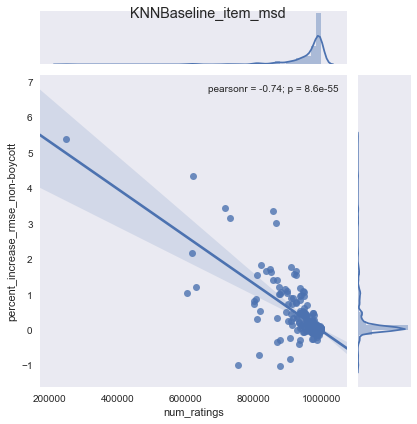

-6.65545495228e-06 6.63240943218 -0.742283000273 8.55492021854e-55
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.904783519136663}})


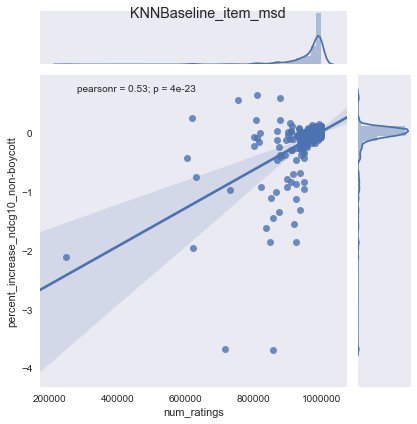

3.24333925748e-06 -3.22654021307 0.525450918893 4.04793828729e-23
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.904783519136663, 'ndcg10': -2.7088052974294894}})


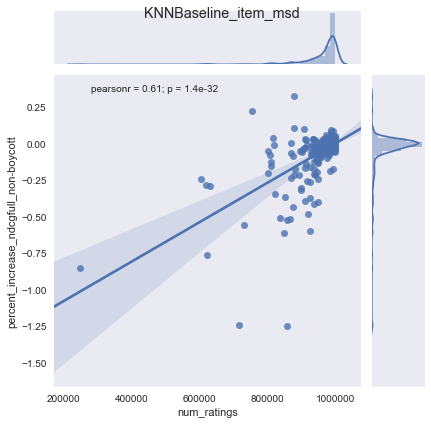

1.34776686867e-06 -1.34804547877 0.609967028376 1.43238086948e-32
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.904783519136663, 'ndcg10': -2.7088052974294894, 'ndcgfull': -0.8029493845902661}})


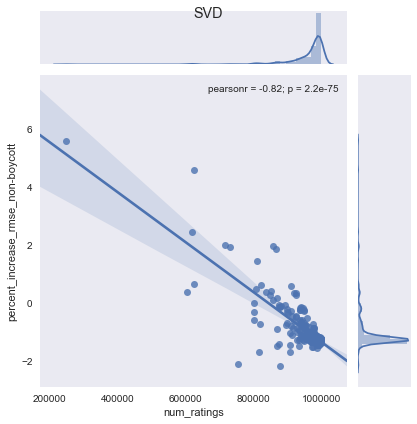

-8.59091972866e-06 7.2417783121 -0.819204470615 2.19068358134e-75
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.904783519136663, 'ndcg10': -2.7088052974294894, 'ndcgfull': -0.8029493845902661}, 'SVD': {'rmse': 11.866427862381508}})


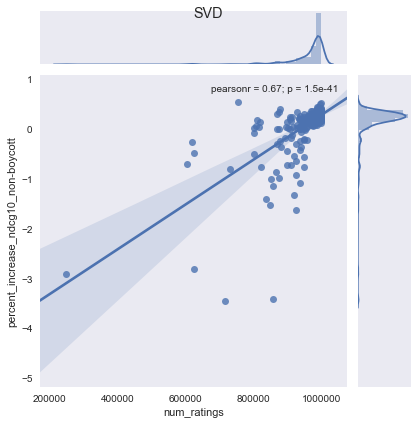

4.49153848257e-06 -4.21382799556 0.671914532406 1.54769894835e-41
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.904783519136663, 'ndcg10': -2.7088052974294894, 'ndcgfull': -0.8029493845902661}, 'SVD': {'rmse': 11.866427862381508, 'ndcg10': -2.9437475748406507}})


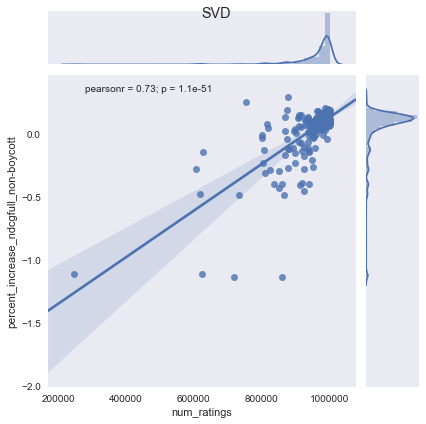

1.85095498554e-06 -1.72179860776 0.727542313421 1.12629990767e-51
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 11.904783519136663, 'ndcg10': -2.7088052974294894, 'ndcgfull': -0.8029493845902661}, 'SVD': {'rmse': 11.866427862381508, 'ndcg10': -2.9437475748406507, 'ndcgfull': -0.8618463872362383}})


In [281]:
for algo_name in algo_names:
    filt = org_df[org_df.algo_name == algo_name]
    for metric in metrics:
        key = 'percent_increase_{}_non-boycott'.format(metric)
        sns.jointplot(filt.num_ratings, y=filt[key], kind="reg").fig.suptitle(algo_name)
        plt.show()
        slope, intercept, r_value, p_value, std_err = stats.linregress(filt.num_ratings, y=filt[key])
        print(slope, intercept, r_value, p_value)
        algo_to_metric_to_slope[algo_name][metric] = slope
        algo_to_metric_to_intercept[algo_name][metric] = intercept
        
        # calculate the average error for all boycott users in each dataframe
        algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
            samples_df[(
                (samples_df.algo_name == algo_name) &
                (samples_df.userfrac == 1.0) & 
                (samples_df.ratingfrac == 1.0)
            )][key.replace('non-boycott', 'boycott')]
        )

        print(algo_to_metric_to_average_boycott)

In [282]:
# list(samples_df.columns.values)

In [283]:
def select_cols(cols, metrics, groups, percents):
    """ rename?"""
    increase_cols = [
        x for x in cols if (any(metric in x for metric in metrics) and 'increase' in x)
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    print(increase_cols)
    return increase_cols

In [284]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [285]:
def p_b_curve(df, metrics, groups, percents=False, lm_plot=False, reg_plot=True):
    algo_to_metric_to_interp = defaultdict(dict)
    if lm_plot:
        increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
        longform = df[increase_cols + id_vars].melt(
            id_vars = id_vars,
            var_name='increase_type'
        )
        longform = fill_in_longform(longform)
        
#         plot1 = sns.lmplot(
#             x="num_users_boycotting", y="value", hue="algo_name", data=longform,
#             size=6, row='metric',
#             order=2,
#         )
#         if percents:
#             plot1.set_ylabels("percent increase")
#         else:
#             plot1.set_ylabels("increase")
#        plot1.set_xlabels('Percent of Users')
        
        sns.lmplot(
            x="num_users_boycotting", y="value", hue="algo_name", data=longform,
            size=6, row='metric',
            order=2, x_estimator=np.mean
        )
        # CALC LOG PLOT
#         vals = [float(x) for x in list(longform.value)]
#         minval = np.min(vals)
#         shifted = vals + - minval + 0.00001
#         print(np.min(shifted))
#         longform = longform.assign(logy = np.log2(shifted))
#         g = sns.lmplot(
#             x="num_users_boycotting", y="logy", hue="algo_name", data=longform,
#             size=6, row='metric',
#             x_estimator=np.mean,
#             order=2
#         )
    
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            key = 'increase_{}_non-boycott'.format(metric)
            if percents:
                key = 'percent_' + key
            x = filt.num_users_boycotting
            user_nums = list(set(filt.num_users_boycotting))
            y = filt[key]
            
            num_to_mean = {}
            for num_users_boycotting in user_nums:
                filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
            meany = np.array(list(num_to_mean.values()))
            
            smoothf = interp1d(user_nums, meany, kind='cubic', bounds_error=False, fill_value='extrapolate')
            algo_to_metric_to_interp[algo_name][metric] = smoothf
            xnew = np.linspace(min(user_nums), max(user_nums), num=500)
            if reg_plot:
                _, ax = plt.subplots()
                g = sns.regplot(
                    x=x, y=y,
                    x_estimator=np.mean,
                    x_bins=user_nums,
                    ax=ax,
                    ci=99,
                    fit_reg=False,
                )
                g.set_title(algo_name)
                
                plt.plot(xnew, smoothf(xnew), '-')
                plt.axhline(0, color='0.5', linestyle='--')
                plt.axhline(algo_to_metric_vs_movie_mean[algo_name][metric], color='0.5', linestyle='--')

    return algo_to_metric_to_interp


Working through log plots
y = log(x)
y = e ^ x
ln(y) = x

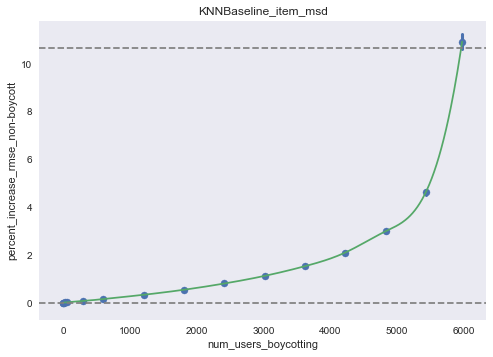

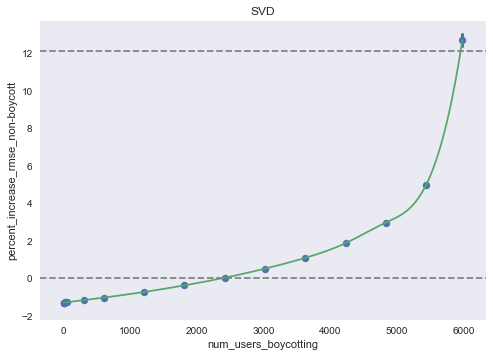

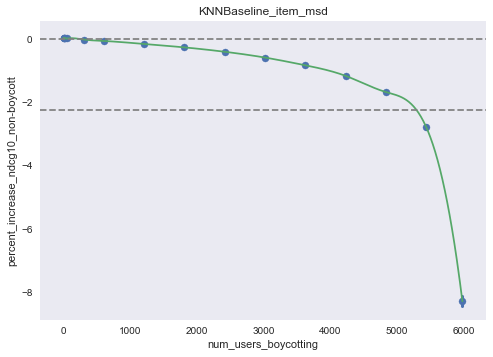

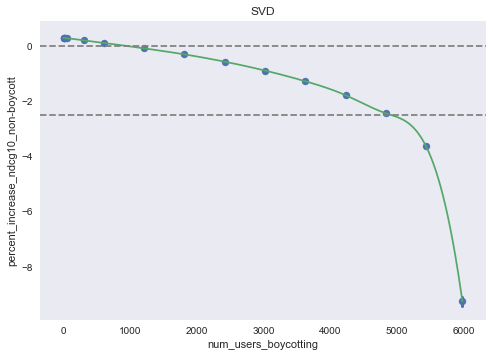

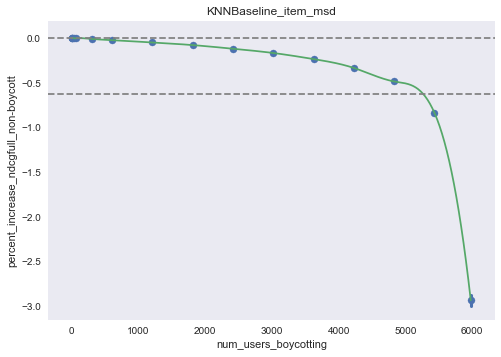

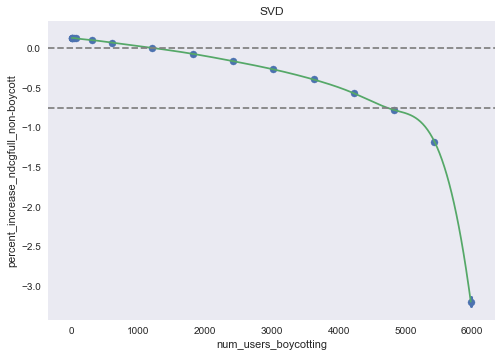

In [286]:
algo_to_metric_to_interp = p_b_curve(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott',]
)
plt.show()

In [287]:
for metric in metrics:
    for algo_name in algo_names:
        key = 'percent_increase_{}_expected'.format(metric)
        expected_vals = algo_to_metric_to_interp[algo_name][metric](org_df.num_users_boycotting)
        print(key)
        kwargs = {key: expected_vals}
        org_df = org_df.assign(**kwargs)

percent_increase_rmse_expected
percent_increase_rmse_expected
percent_increase_ndcg10_expected
percent_increase_ndcg10_expected
percent_increase_ndcgfull_expected
percent_increase_ndcgfull_expected


In [288]:
# Use this cell to show raw values instead of percents.

# g = plot1(
#     samples_df,
#     metrics=['rmse', 'ndcg', 'prec'],
#     percents=False,
#     groups=['non-boycott', 'all',]
# )
# plt.show()

In [289]:
algo_to_metric_vs_movie_mean

defaultdict(dict,
            {'KNNBaseline_item_msd': {'ndcg10': -2.248843148449569,
              'ndcgfull': -0.6264745815763064,
              'rmse': 10.632081538342637},
             'SVD': {'ndcg10': -2.5013010813093173,
              'ndcgfull': -0.7603313165103744,
              'rmse': 12.09654713110365}})

In [290]:
def plot2(df, metrics, groups, percents=False, kind='bar', size=10):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    longform = longform.assign(
        name_plus_ratings=['{} ({}k)'.format(
            name, int(round(num_ratings/1000,0))
        ) for name, num_ratings in zip(longform.name, longform.num_ratings)
    ])
    g = sns.factorplot(
        x="value", y="name", hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        # linestyles='None',
        # capsize=0.1
    )
    a = g.axes
    
    # flag: hardcoded right now. Not good.
    # use .facet_data() ?
    algo_order = ['KNNBaseline_item_msd', 'SVD']
    metric_order = ['ndcg10', 'ndcgfull', 'rmse']
    for y in range(a.shape[0]):
        for x in range(a.shape[1]):
            val = algo_to_metric_vs_movie_mean[algo_order[x]][metric_order[y]]
            g.axes[y,x].axvline(0, color='0.5', linestyle='--')
            g.axes[y,x].axvline(val, color='0.5', linestyle='--')
    return g


In [291]:
state_boycotts = org_df[org_df['type'] == 'state']
gender_boycotts = org_df[org_df['type'] == 'gender']
age_boycotts = org_df[org_df['type'] == 'age']
occupation_boycotts = org_df[org_df['type'] == 'occupation']
power_boycotts = org_df[org_df['type'] == 'power']
genre_boycotts = org_df[org_df['type'] == 'genre']

In [292]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [293]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0)
    )]

In [294]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [295]:
def plot_all_three_scenarios(df, size=6):
    plot2(
        all_users_all_ratings(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'expected'],
        size=size
    ).fig.suptitle('All Users, All Ratings')
    plot2(
        half_users(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'like-boycott', 'expected'],
        size=size
    ).fig.suptitle('Half Users')
    plot2(
        half_ratings(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'boycott', 'expected'],
        size=size,
    ).fig.suptitle('Half Ratings')
    plt.show()

## Let's do gender first...

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']


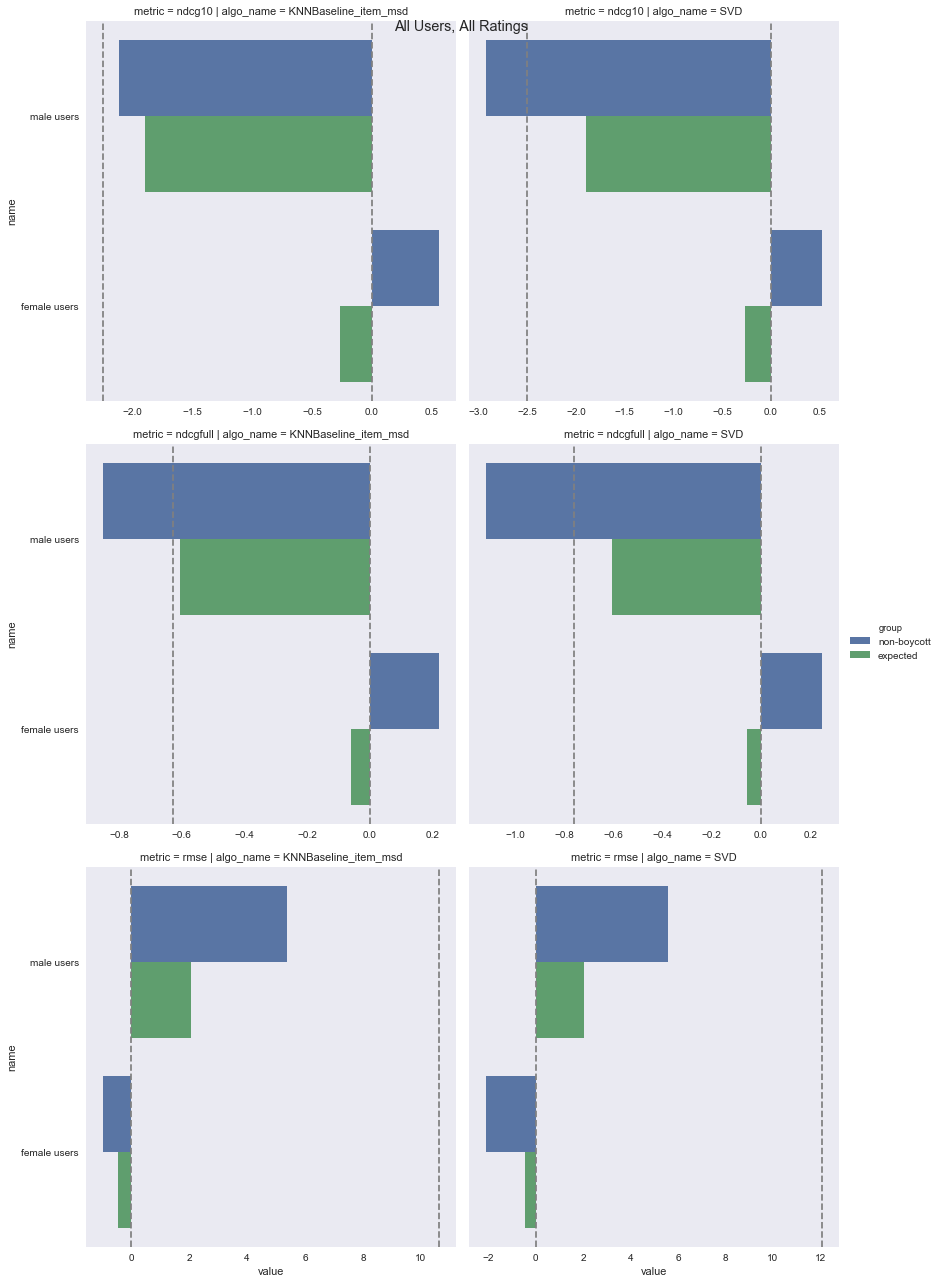

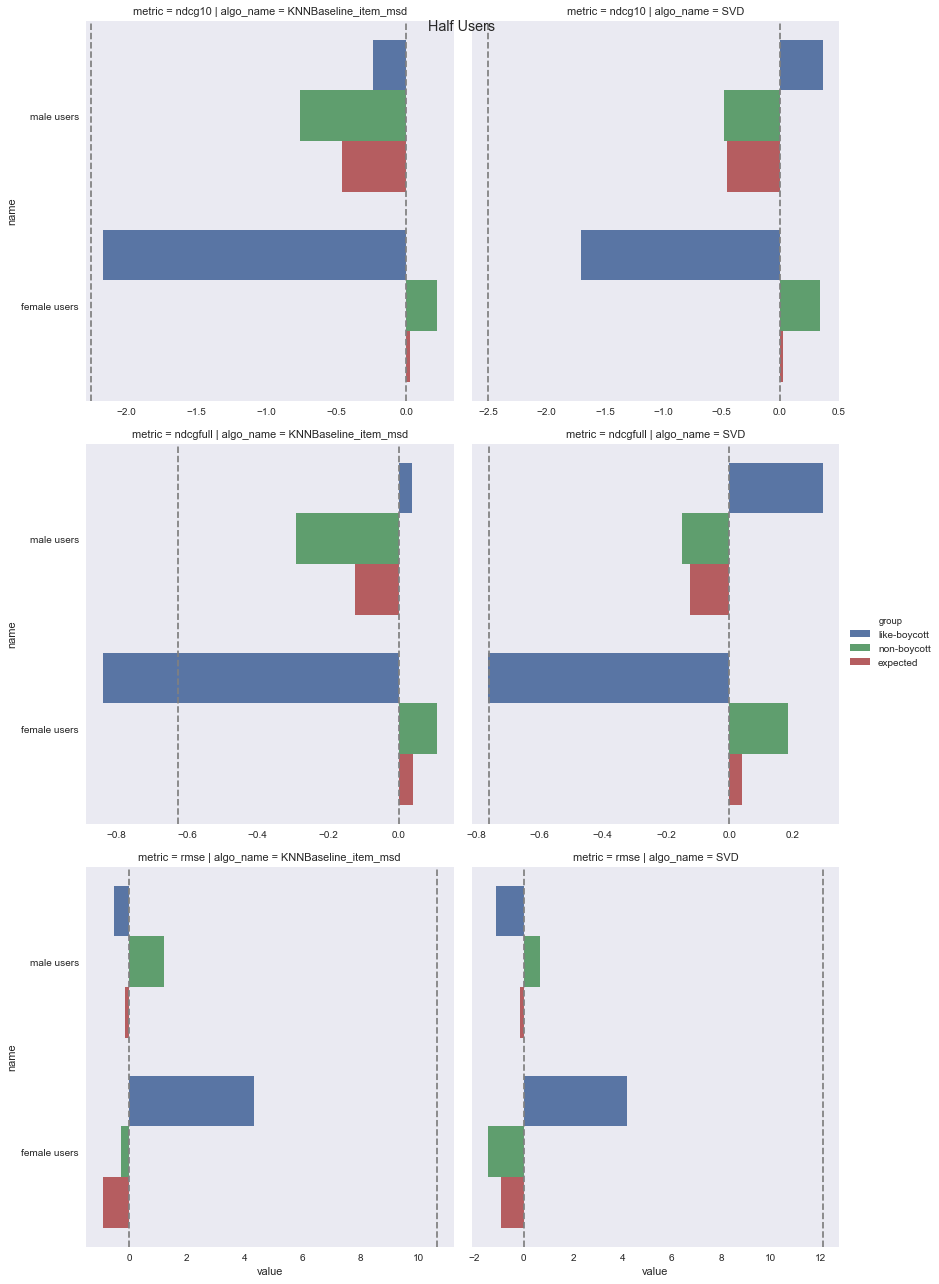

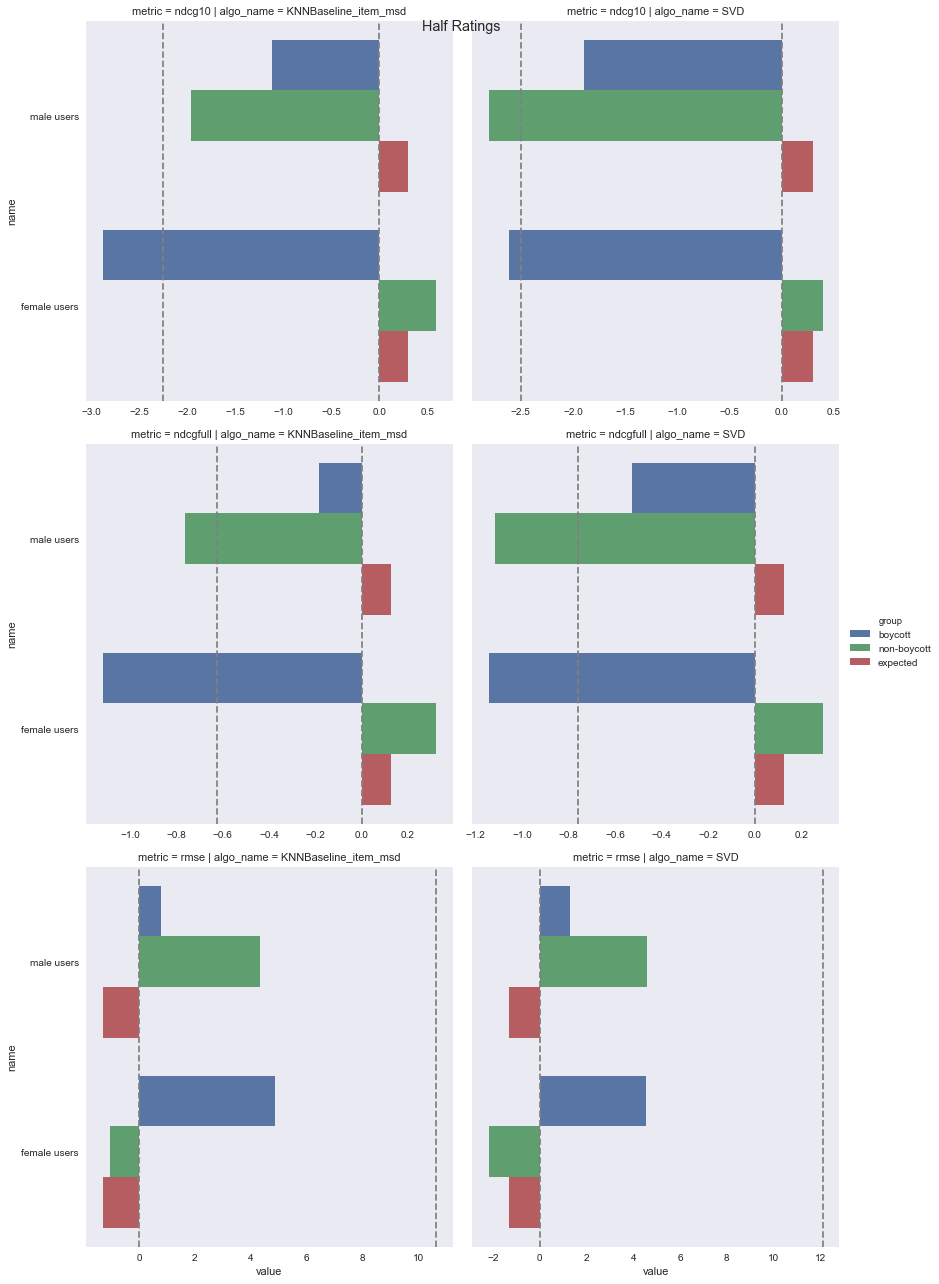

In [296]:
plot_all_three_scenarios(gender_boycotts)

States seemed interesting and slowed the page down a bit, so I commented out for now.
Main conclusion was that state-based boycotts seem to be pretty ineffective for basically every state.
One funny result was that it seems California users have especially low-value ratings - the performance degradation was quite off from the expected degradation (b/c CA has a lot of users).

In [297]:
# plot_all_three_scenarios(state_boycotts, size=12)

Below, the power boycotts show a very weird results. Warrants double checks.

It appears for KNN, removing all power users actually improves performance (as opposed to the large expected drop).
But at the same time, RMSE increases! This is one of the example where RMSE and NDCG do not correlate...

Note the artifact in plot #5 below: it looks like ndcg has a huge increase when bottom 10% users do a half boycott... but this is b/c ndcg@10 is just getting easier to "succeed" for these users

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']


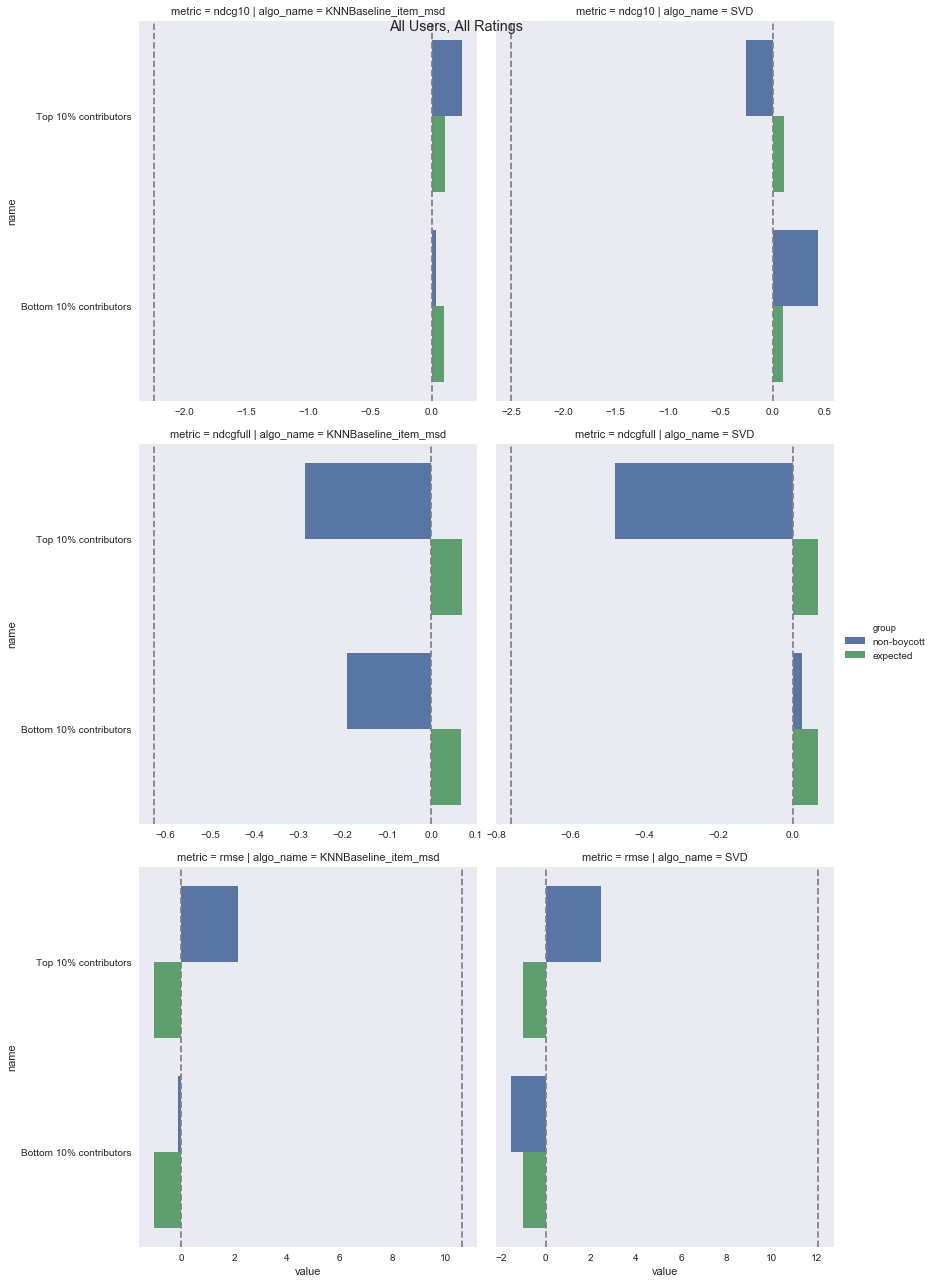

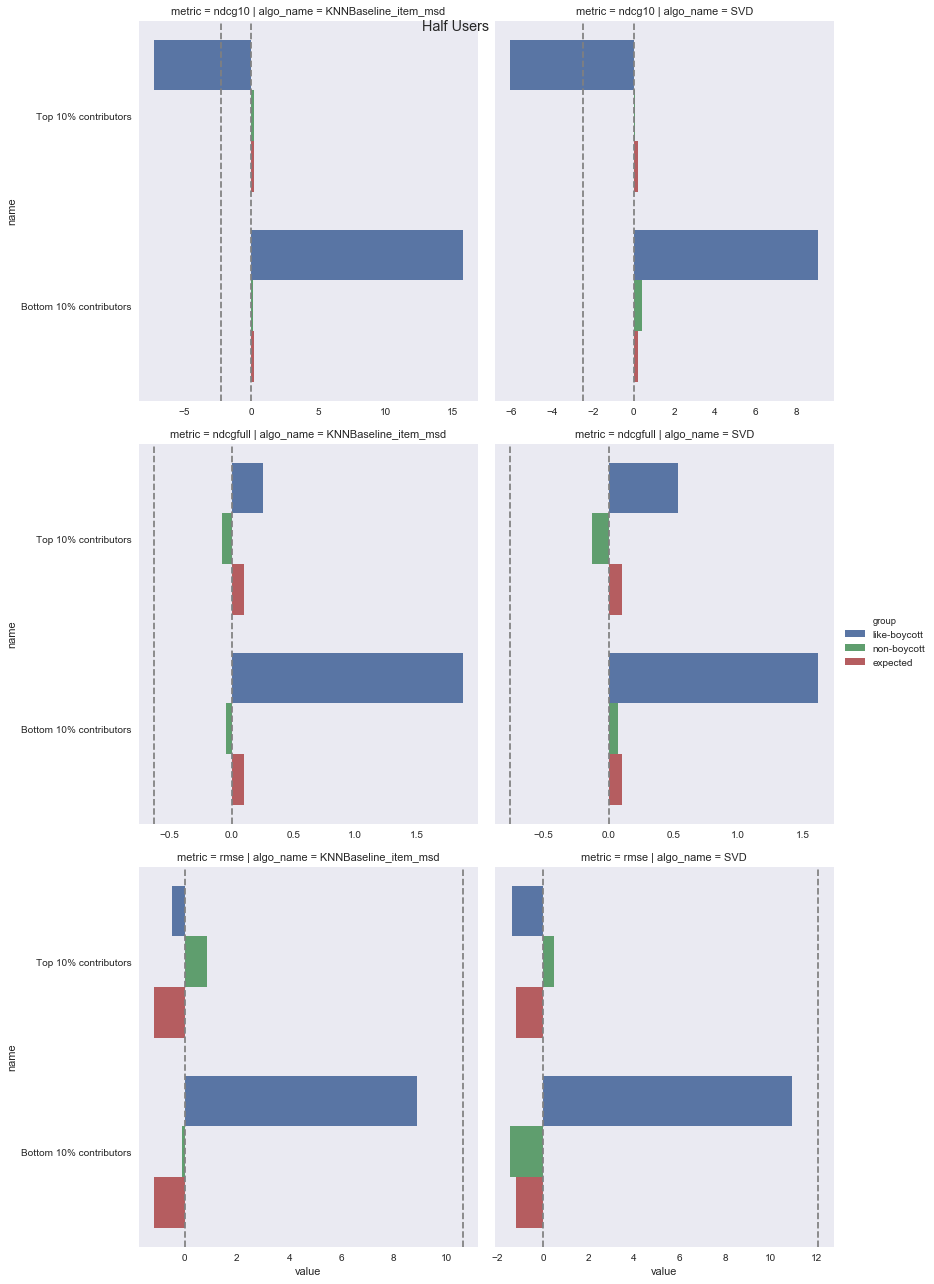

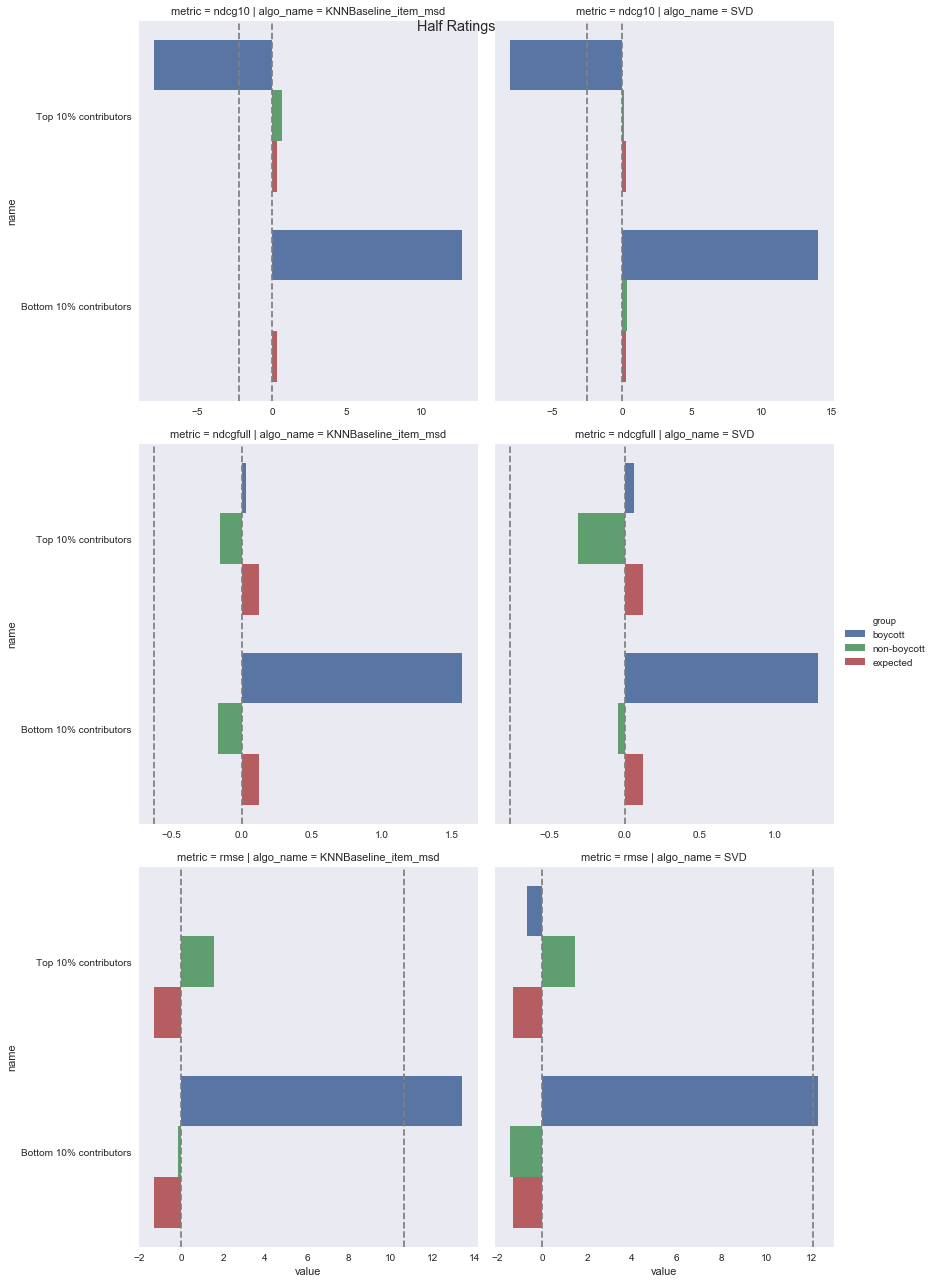

In [298]:
plot_all_three_scenarios(power_boycotts)

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']


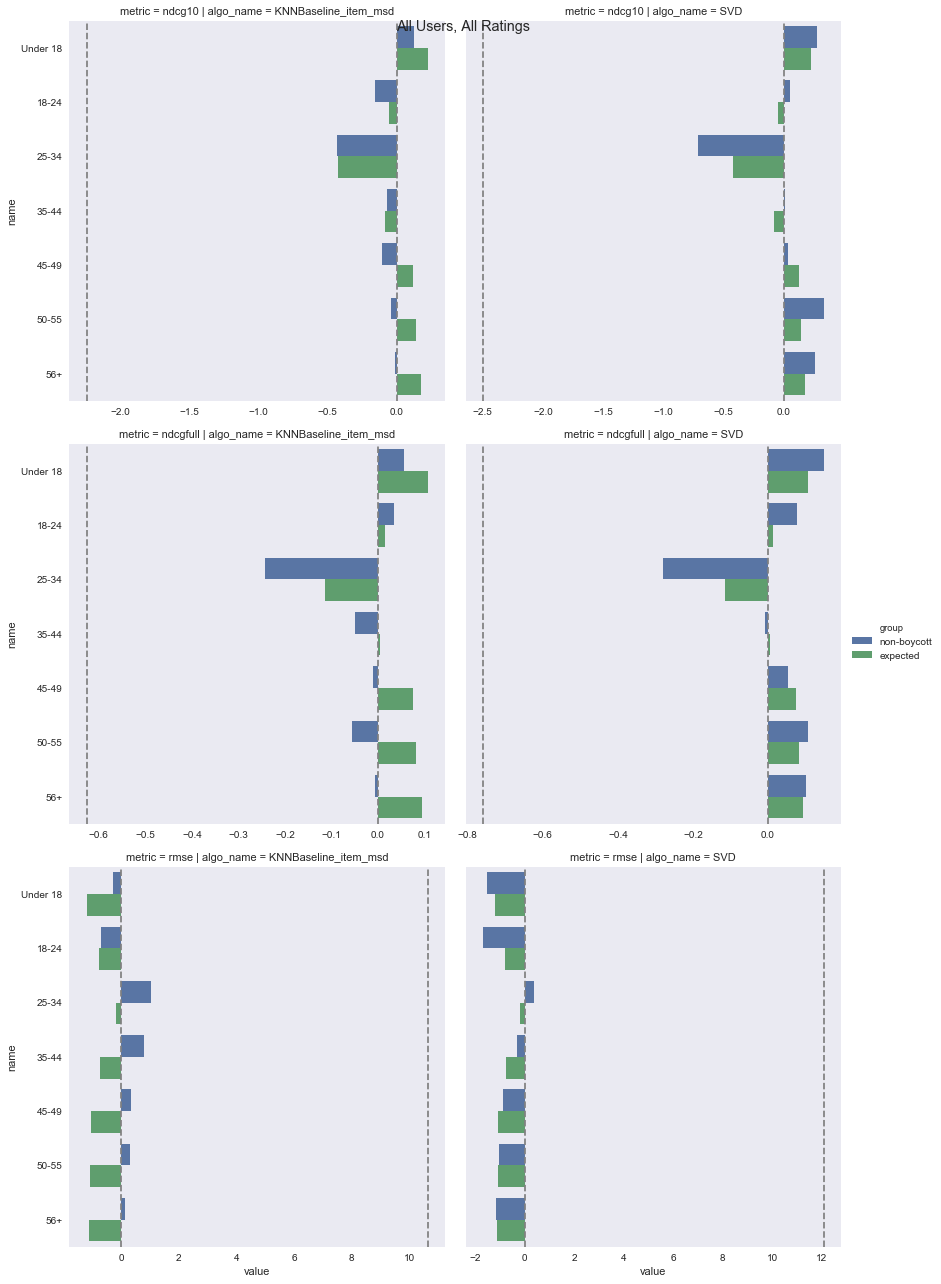

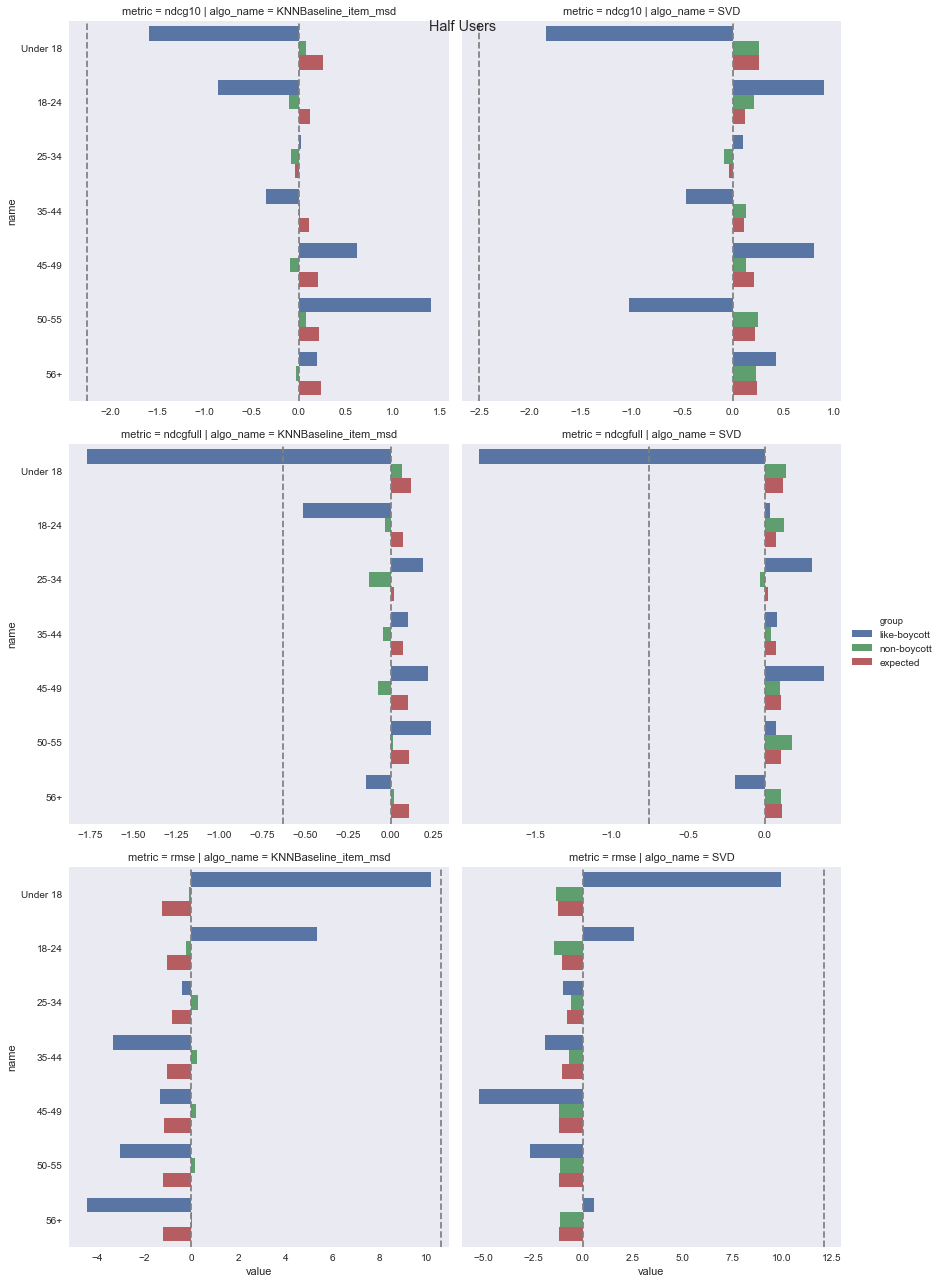

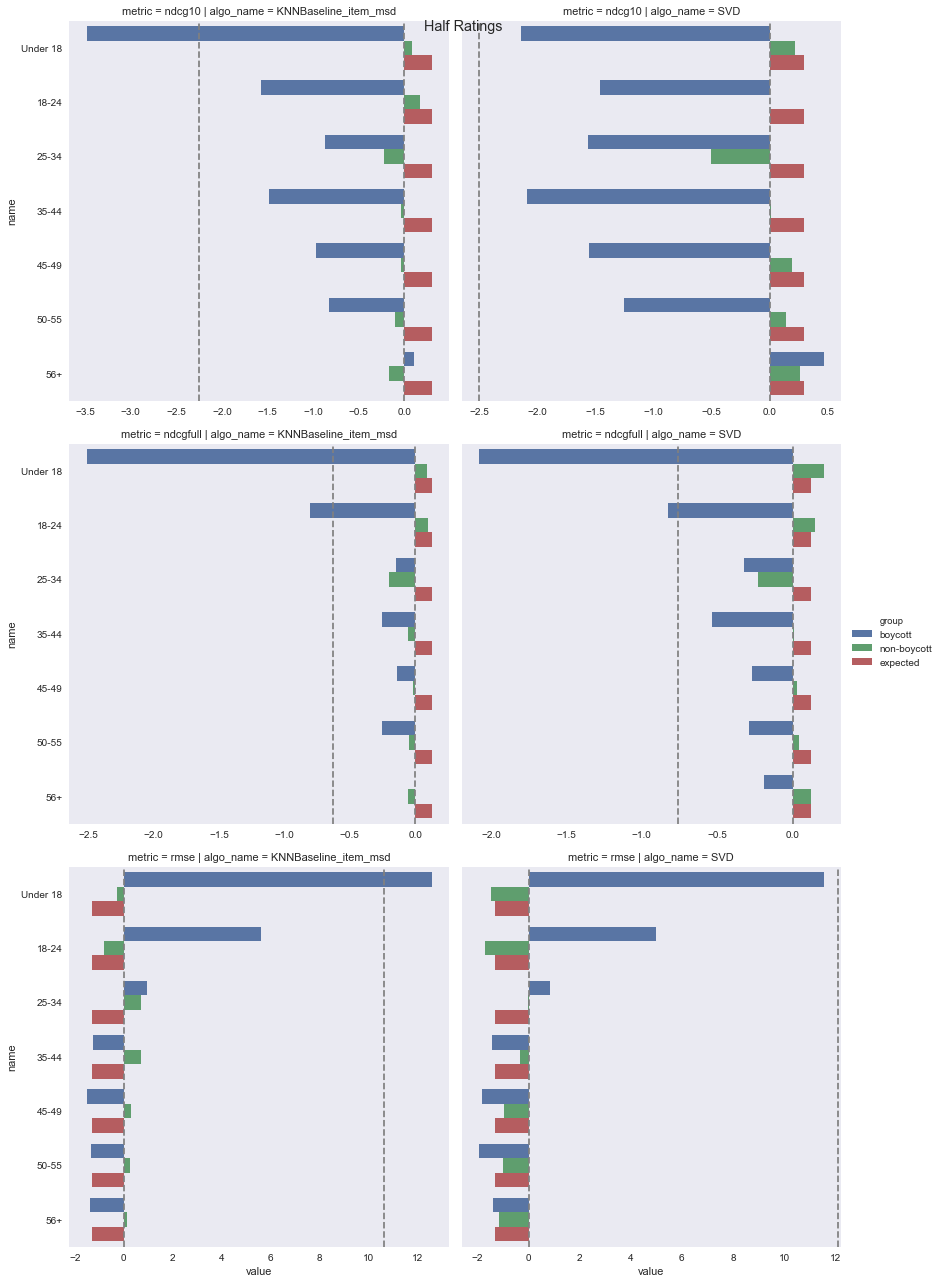

In [299]:
plot_all_three_scenarios(age_boycotts)

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']


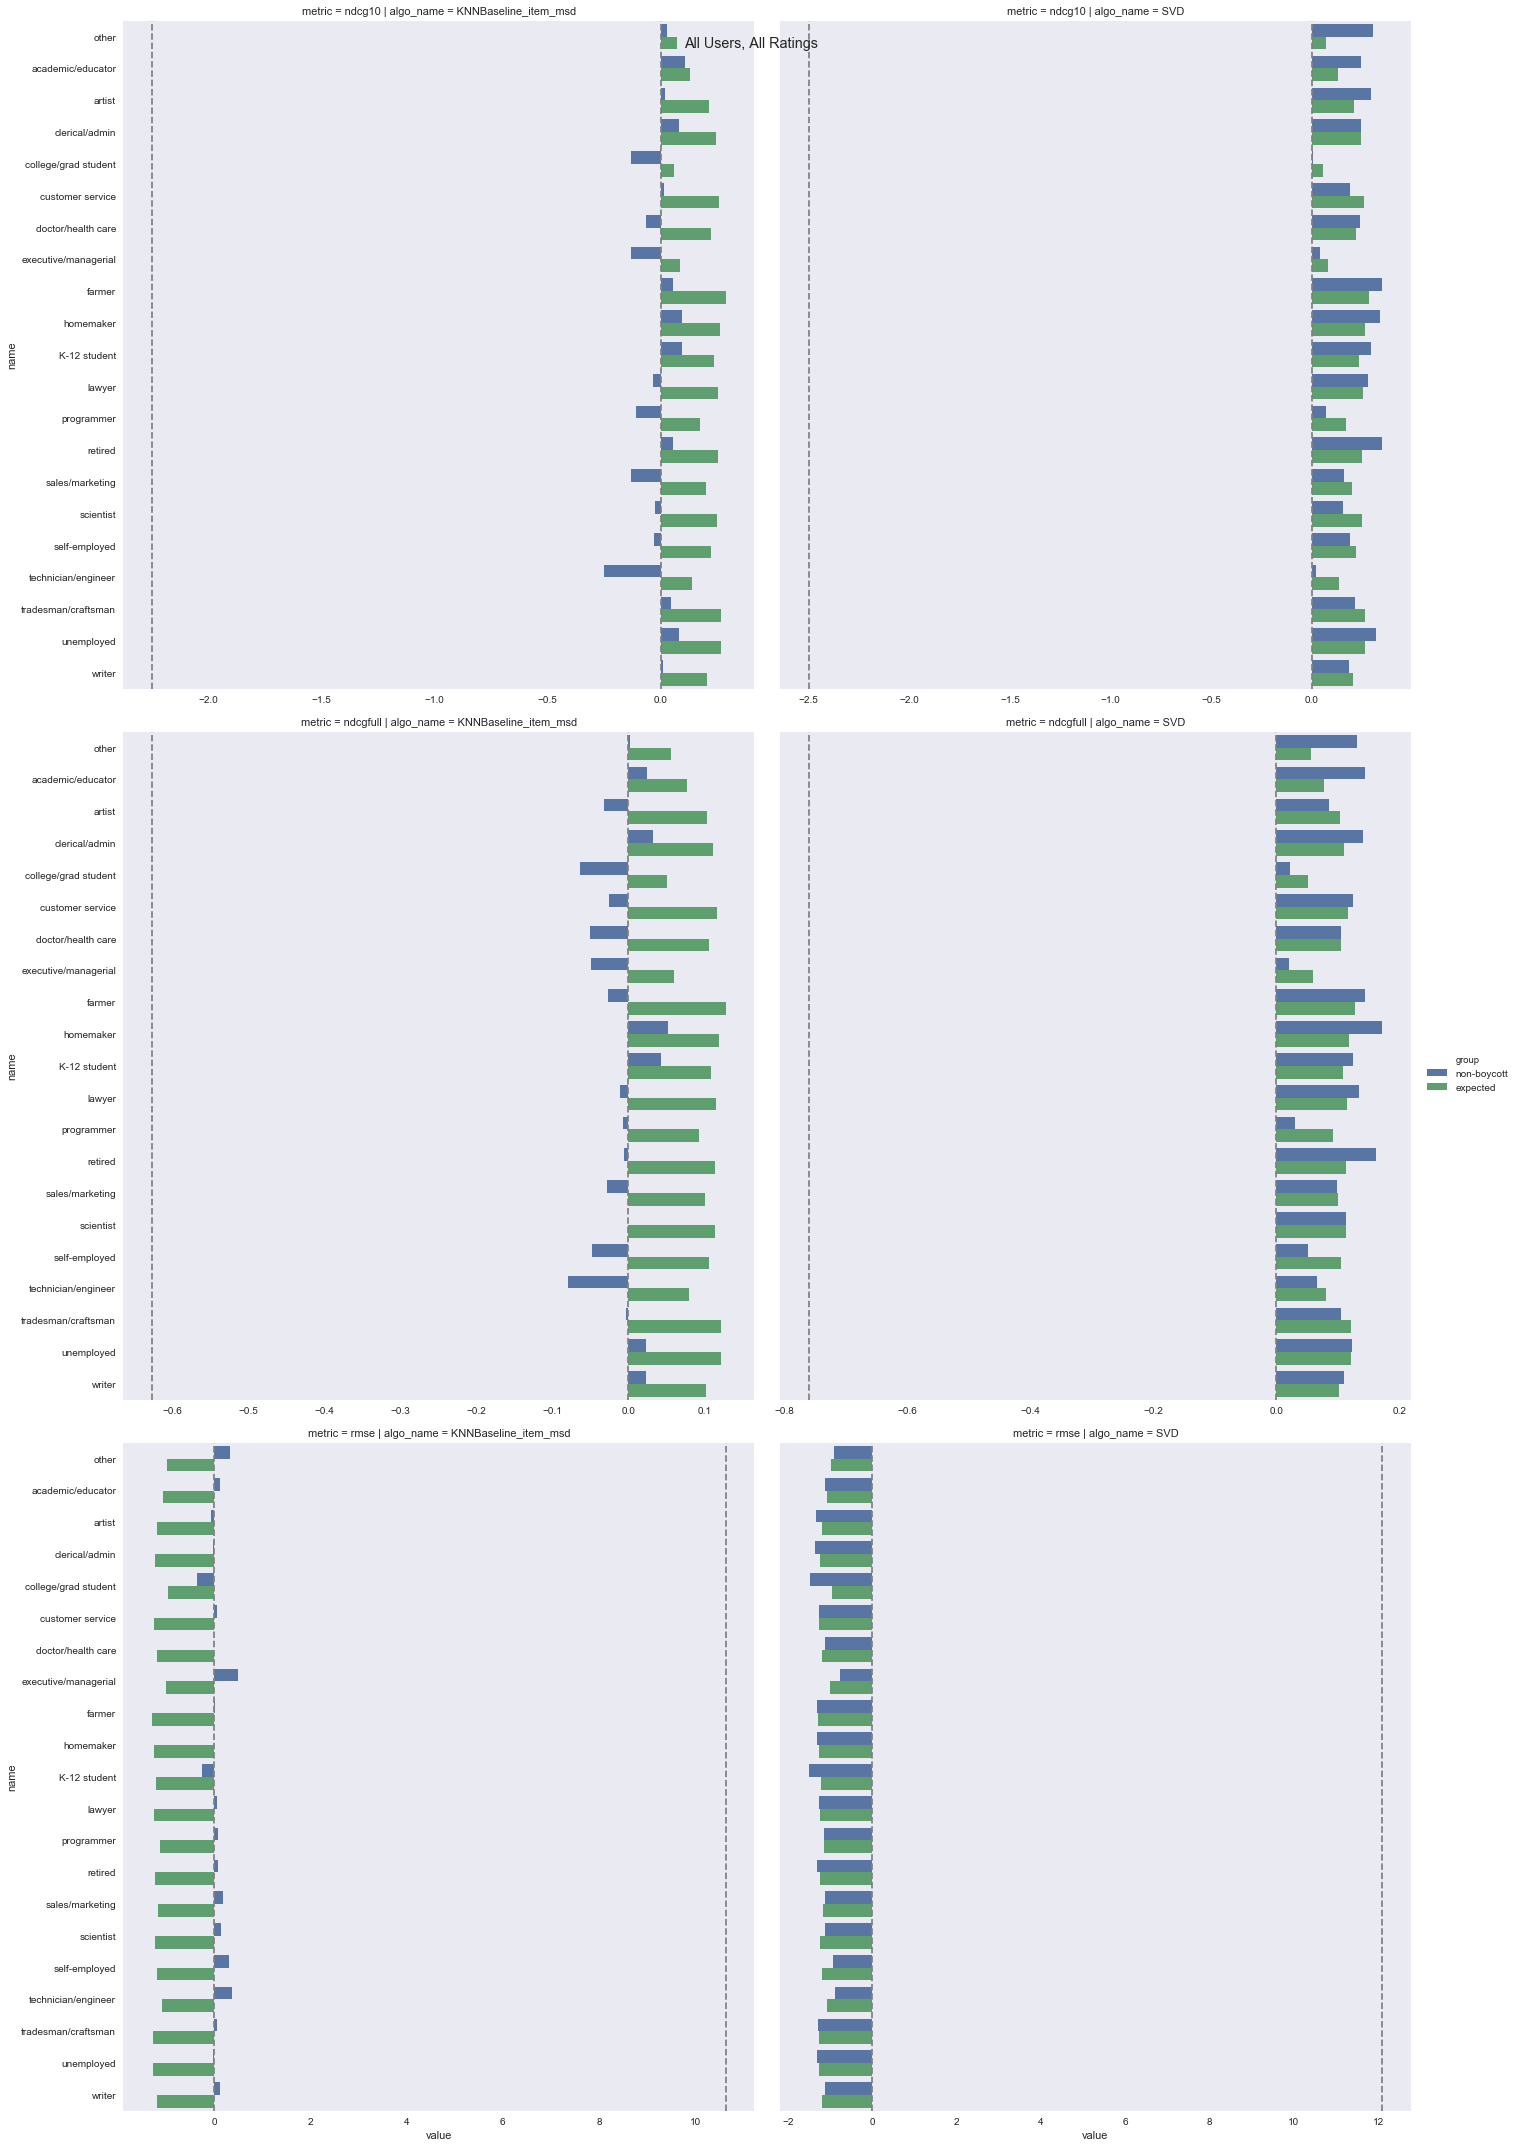

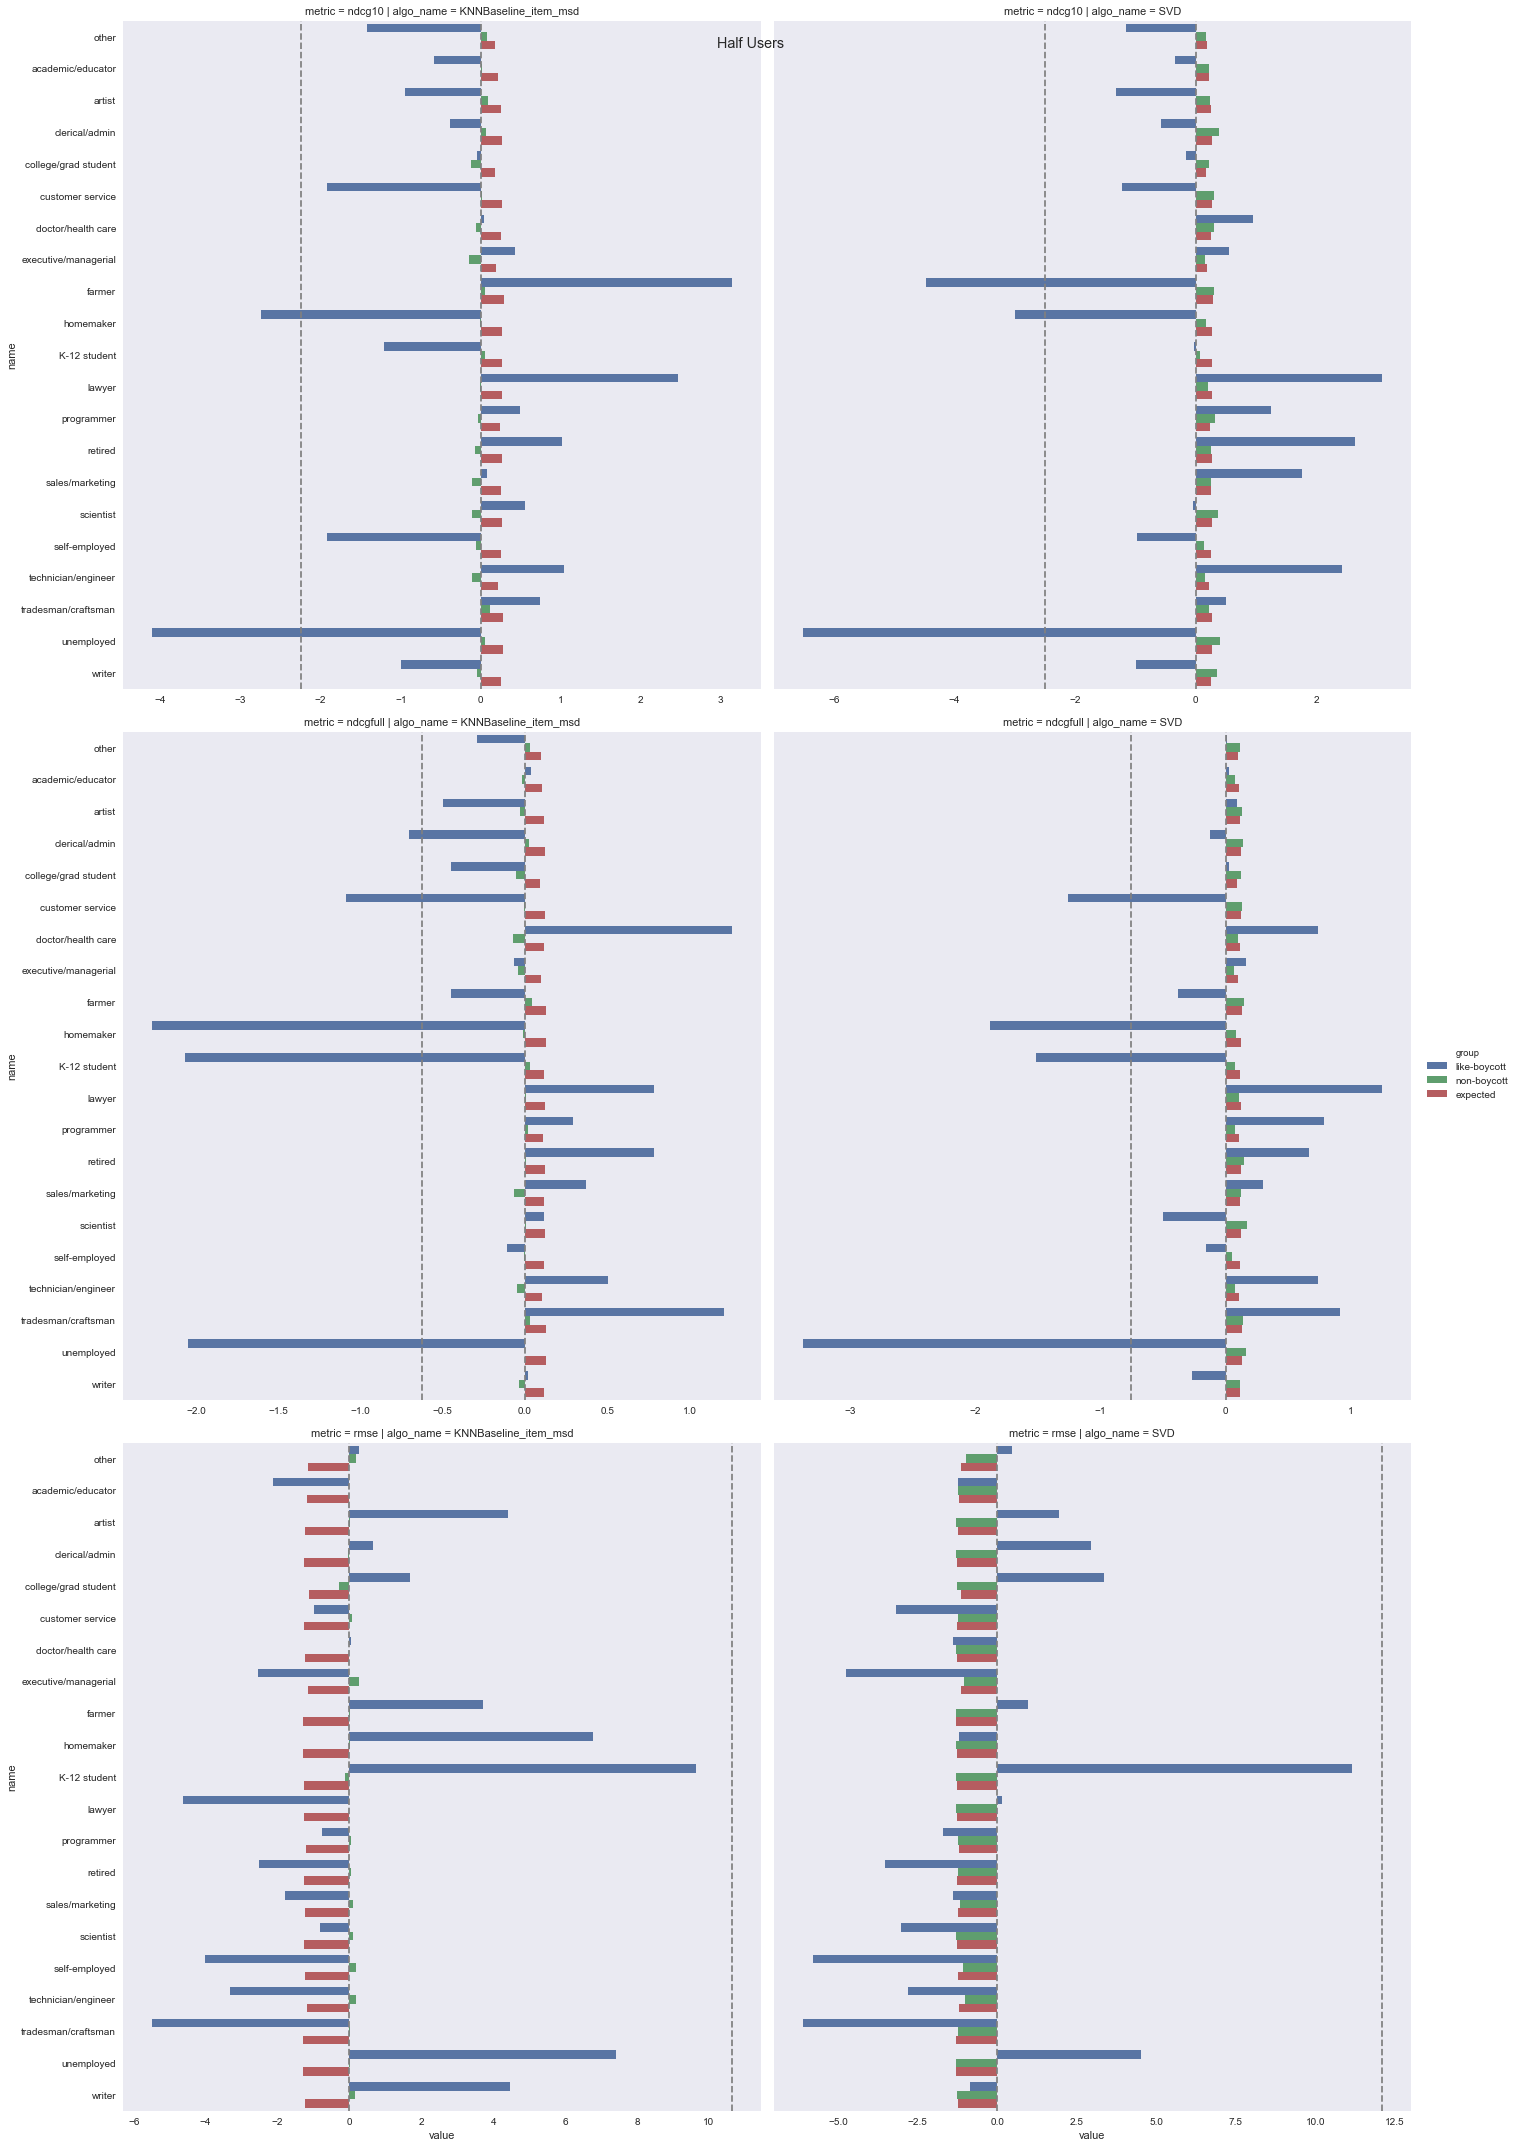

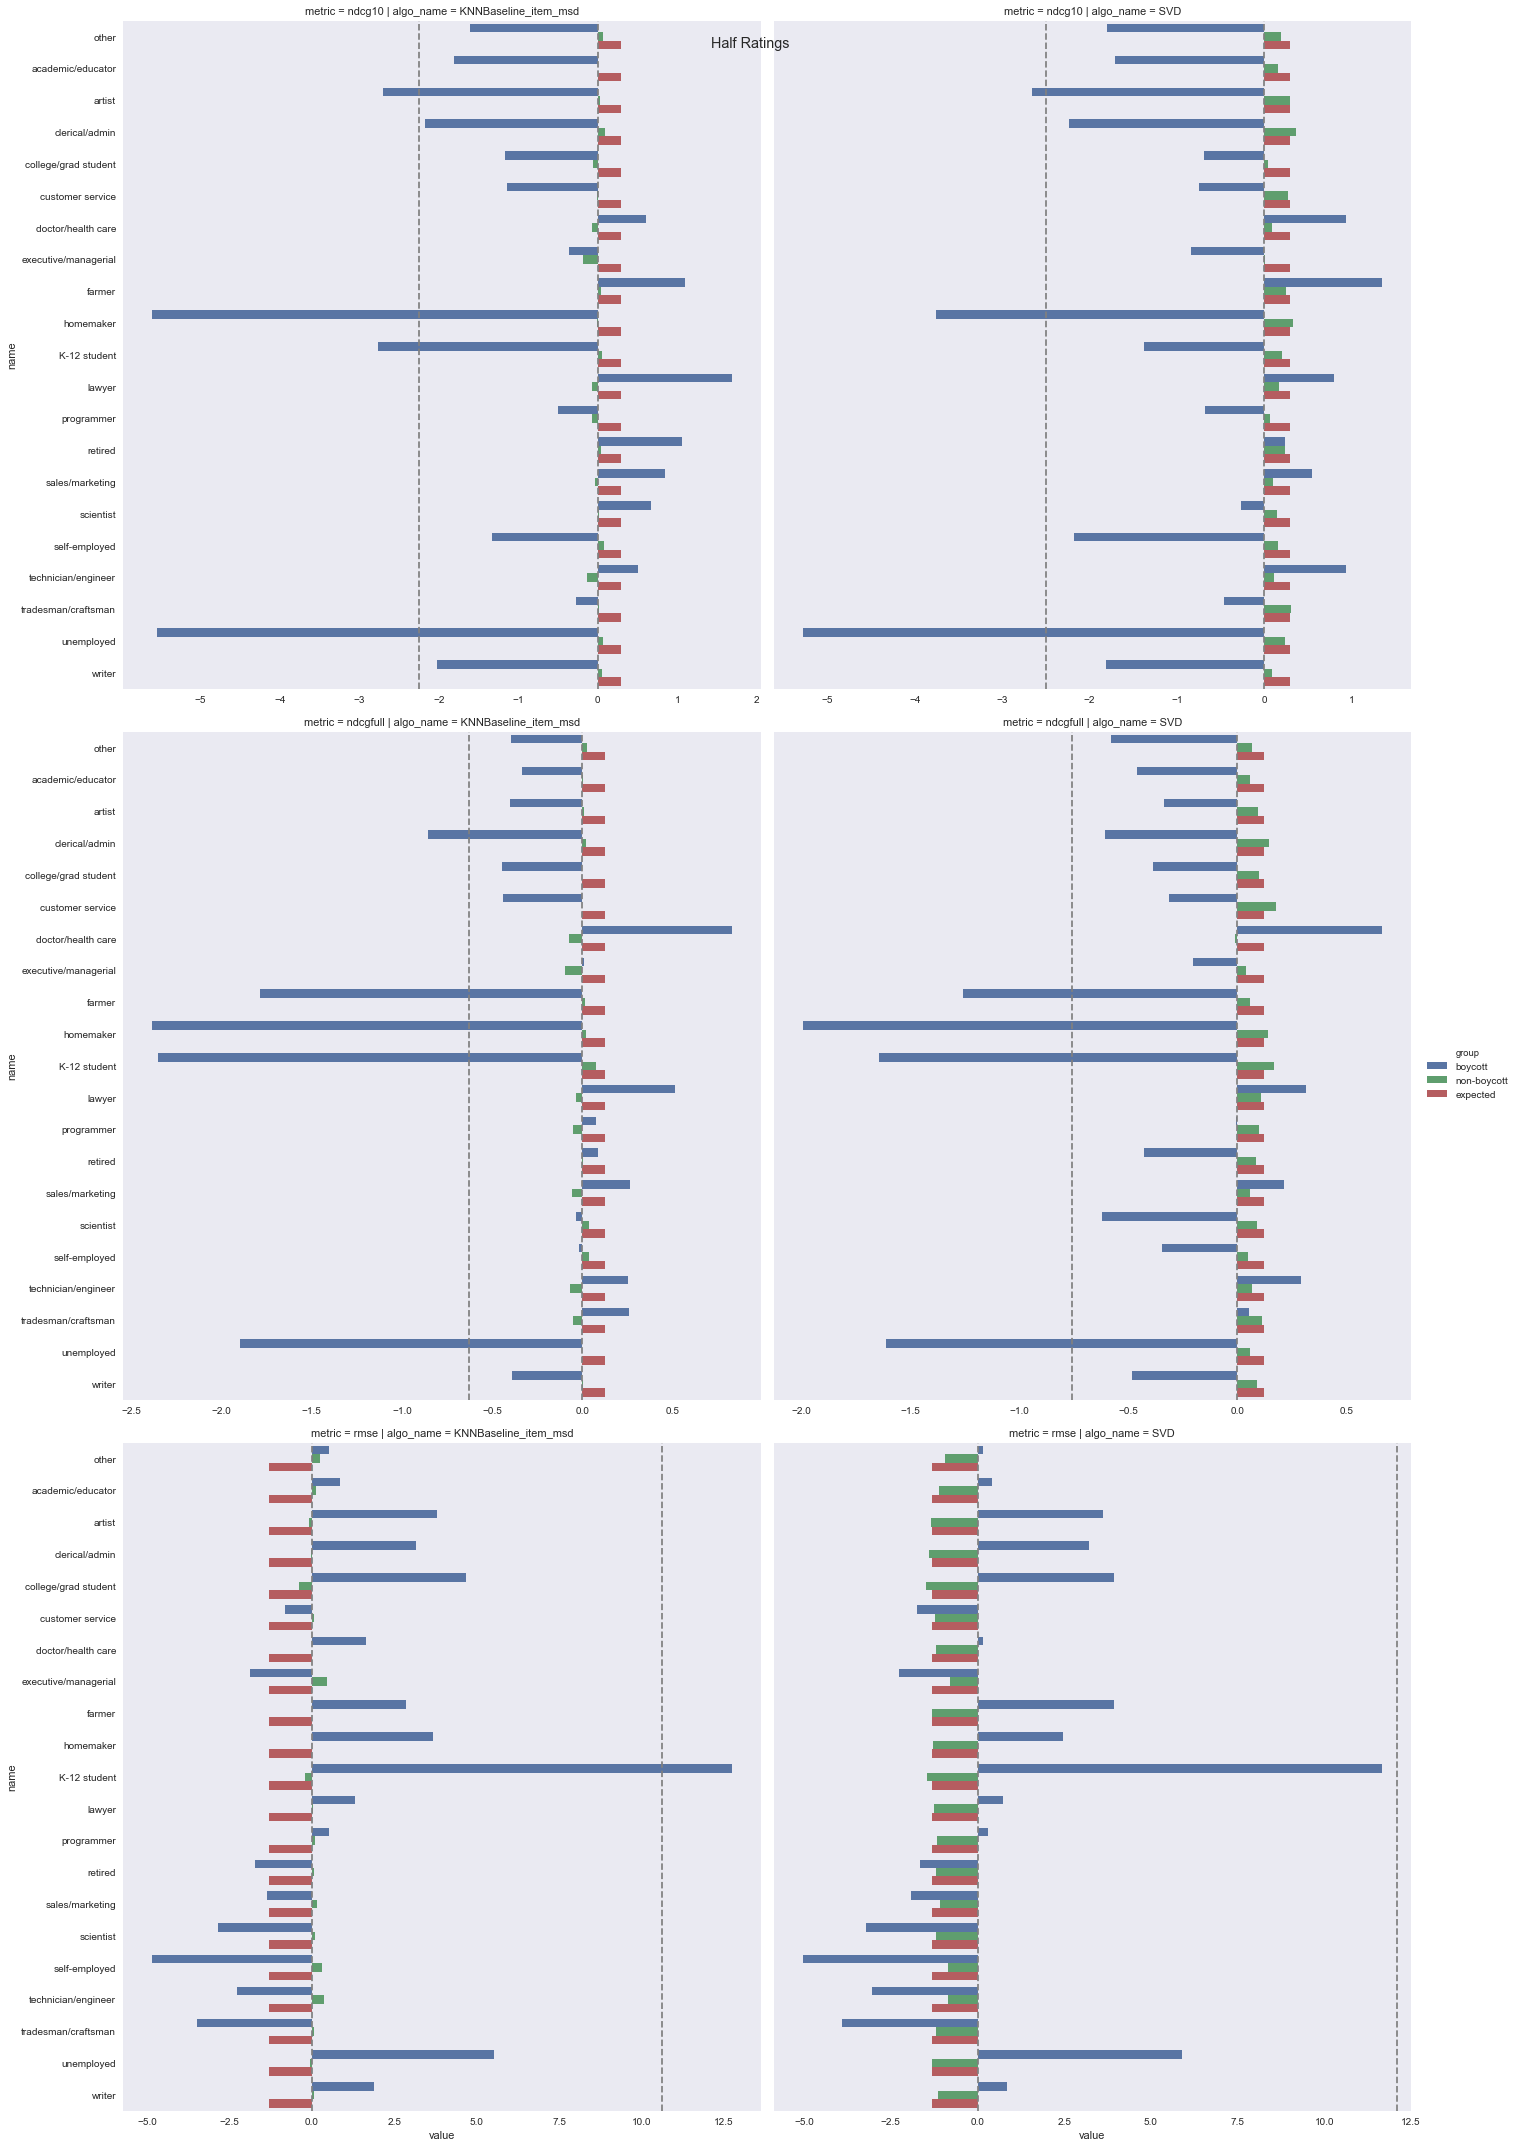

In [300]:
plot_all_three_scenarios(occupation_boycotts, size=10)

['percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_like-boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_ndcgfull_boycott', 'percent_increase_ndcgfull_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected', 'percent_increase_ndcgfull_expected']


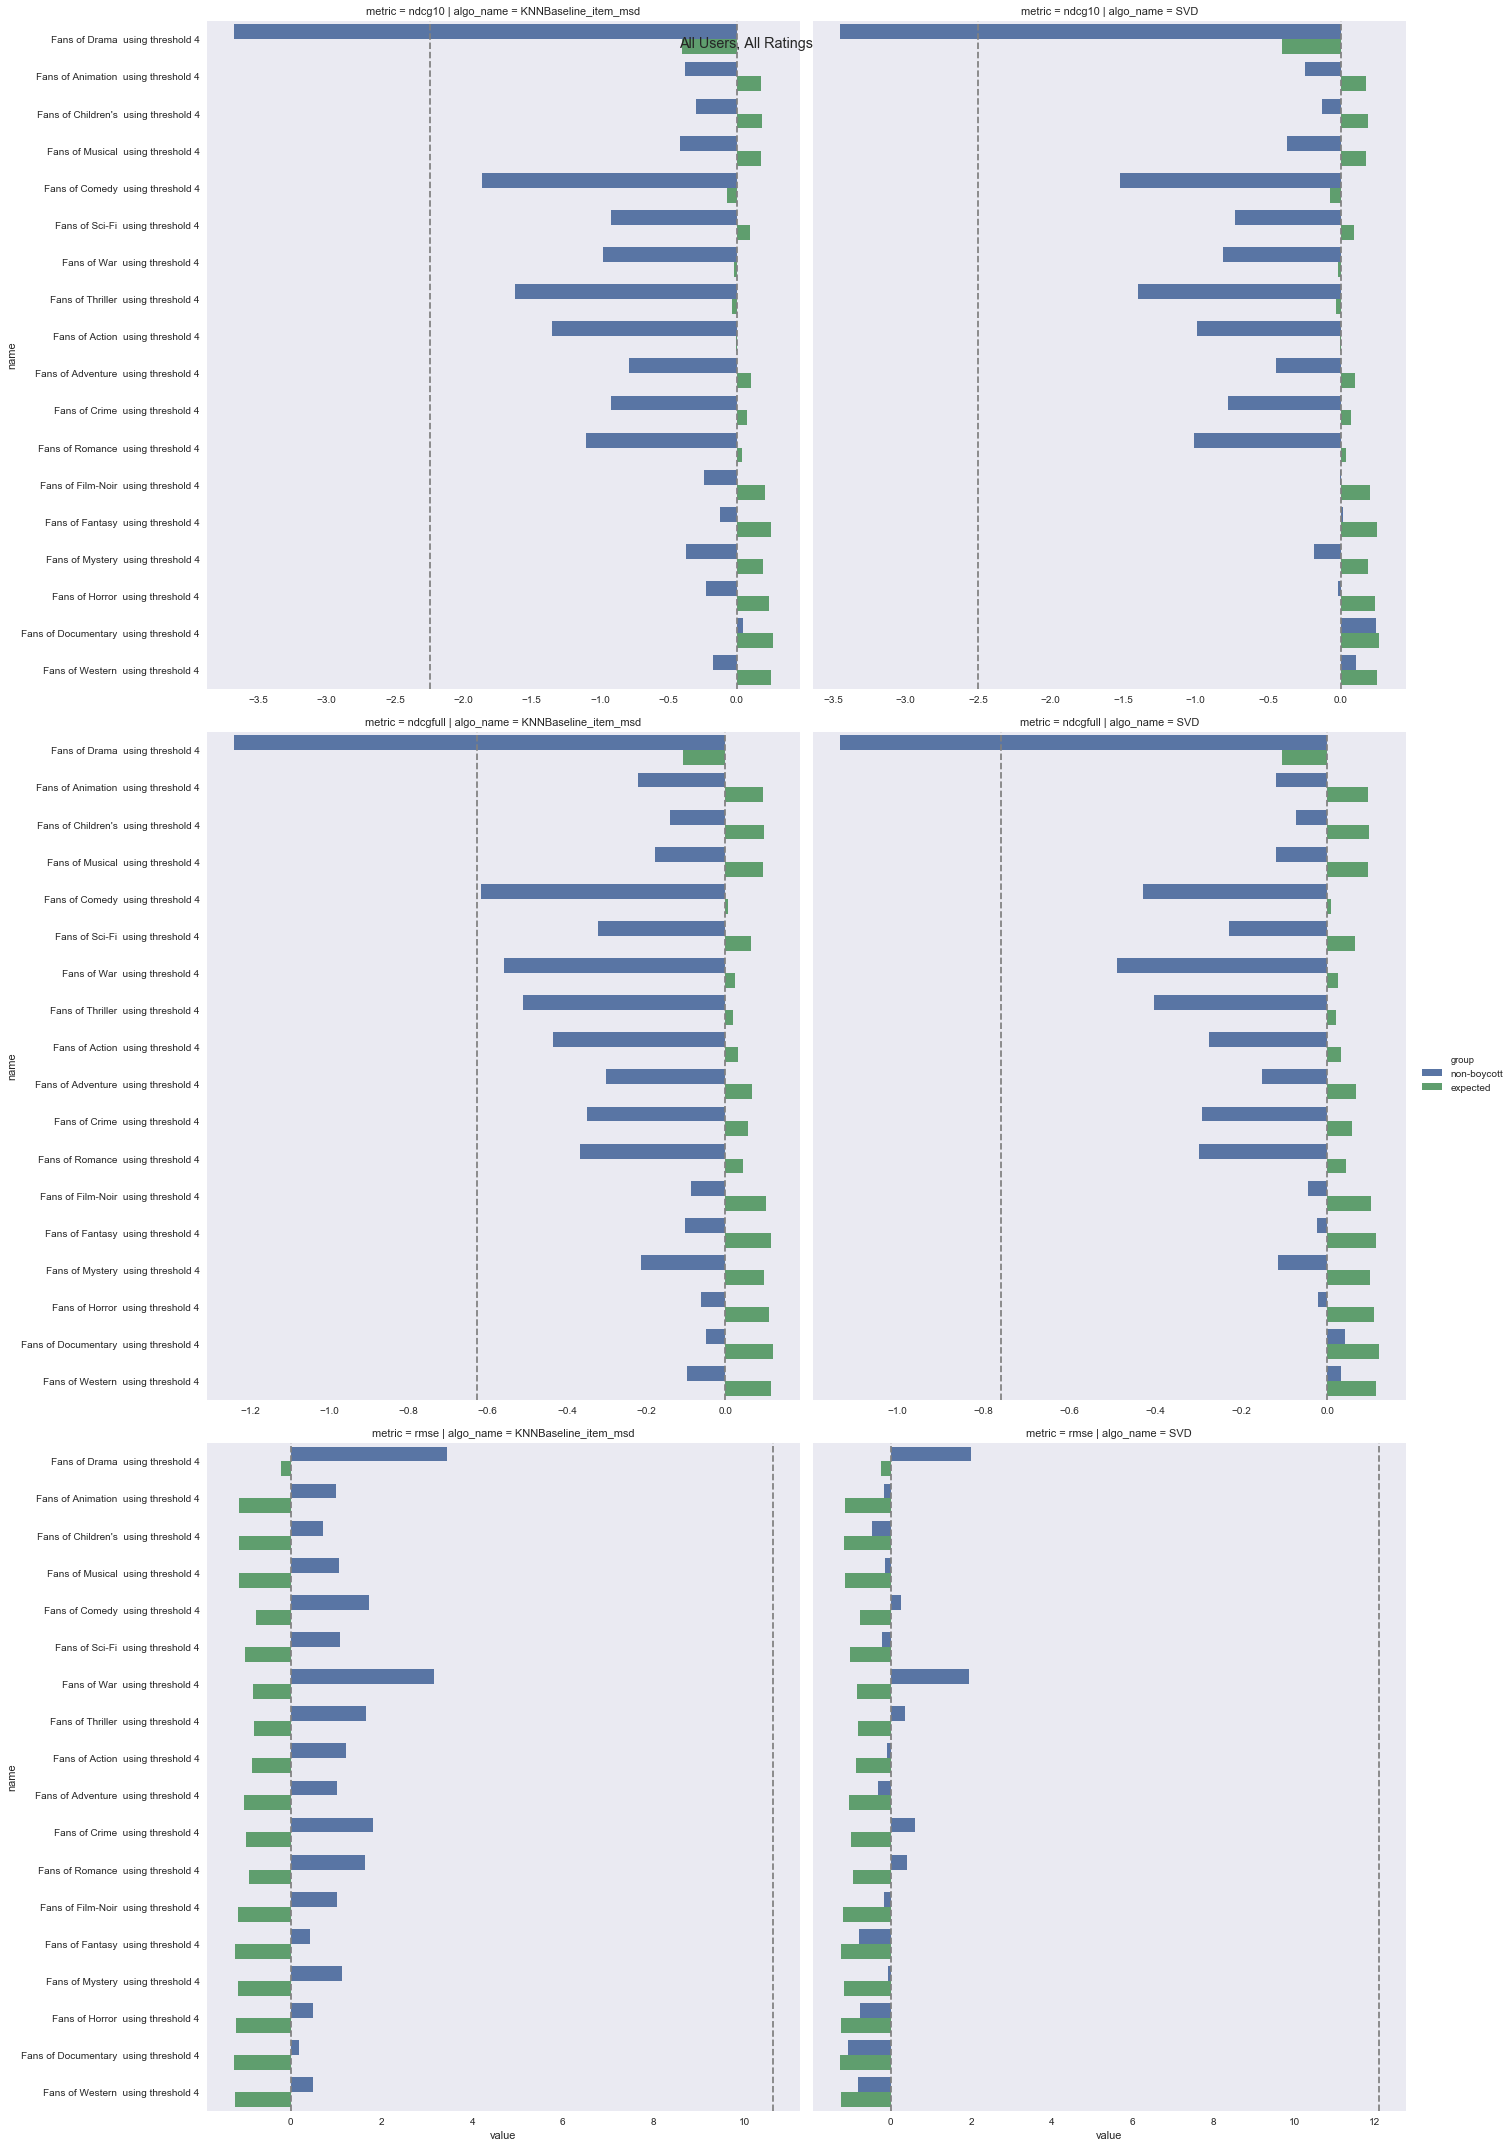

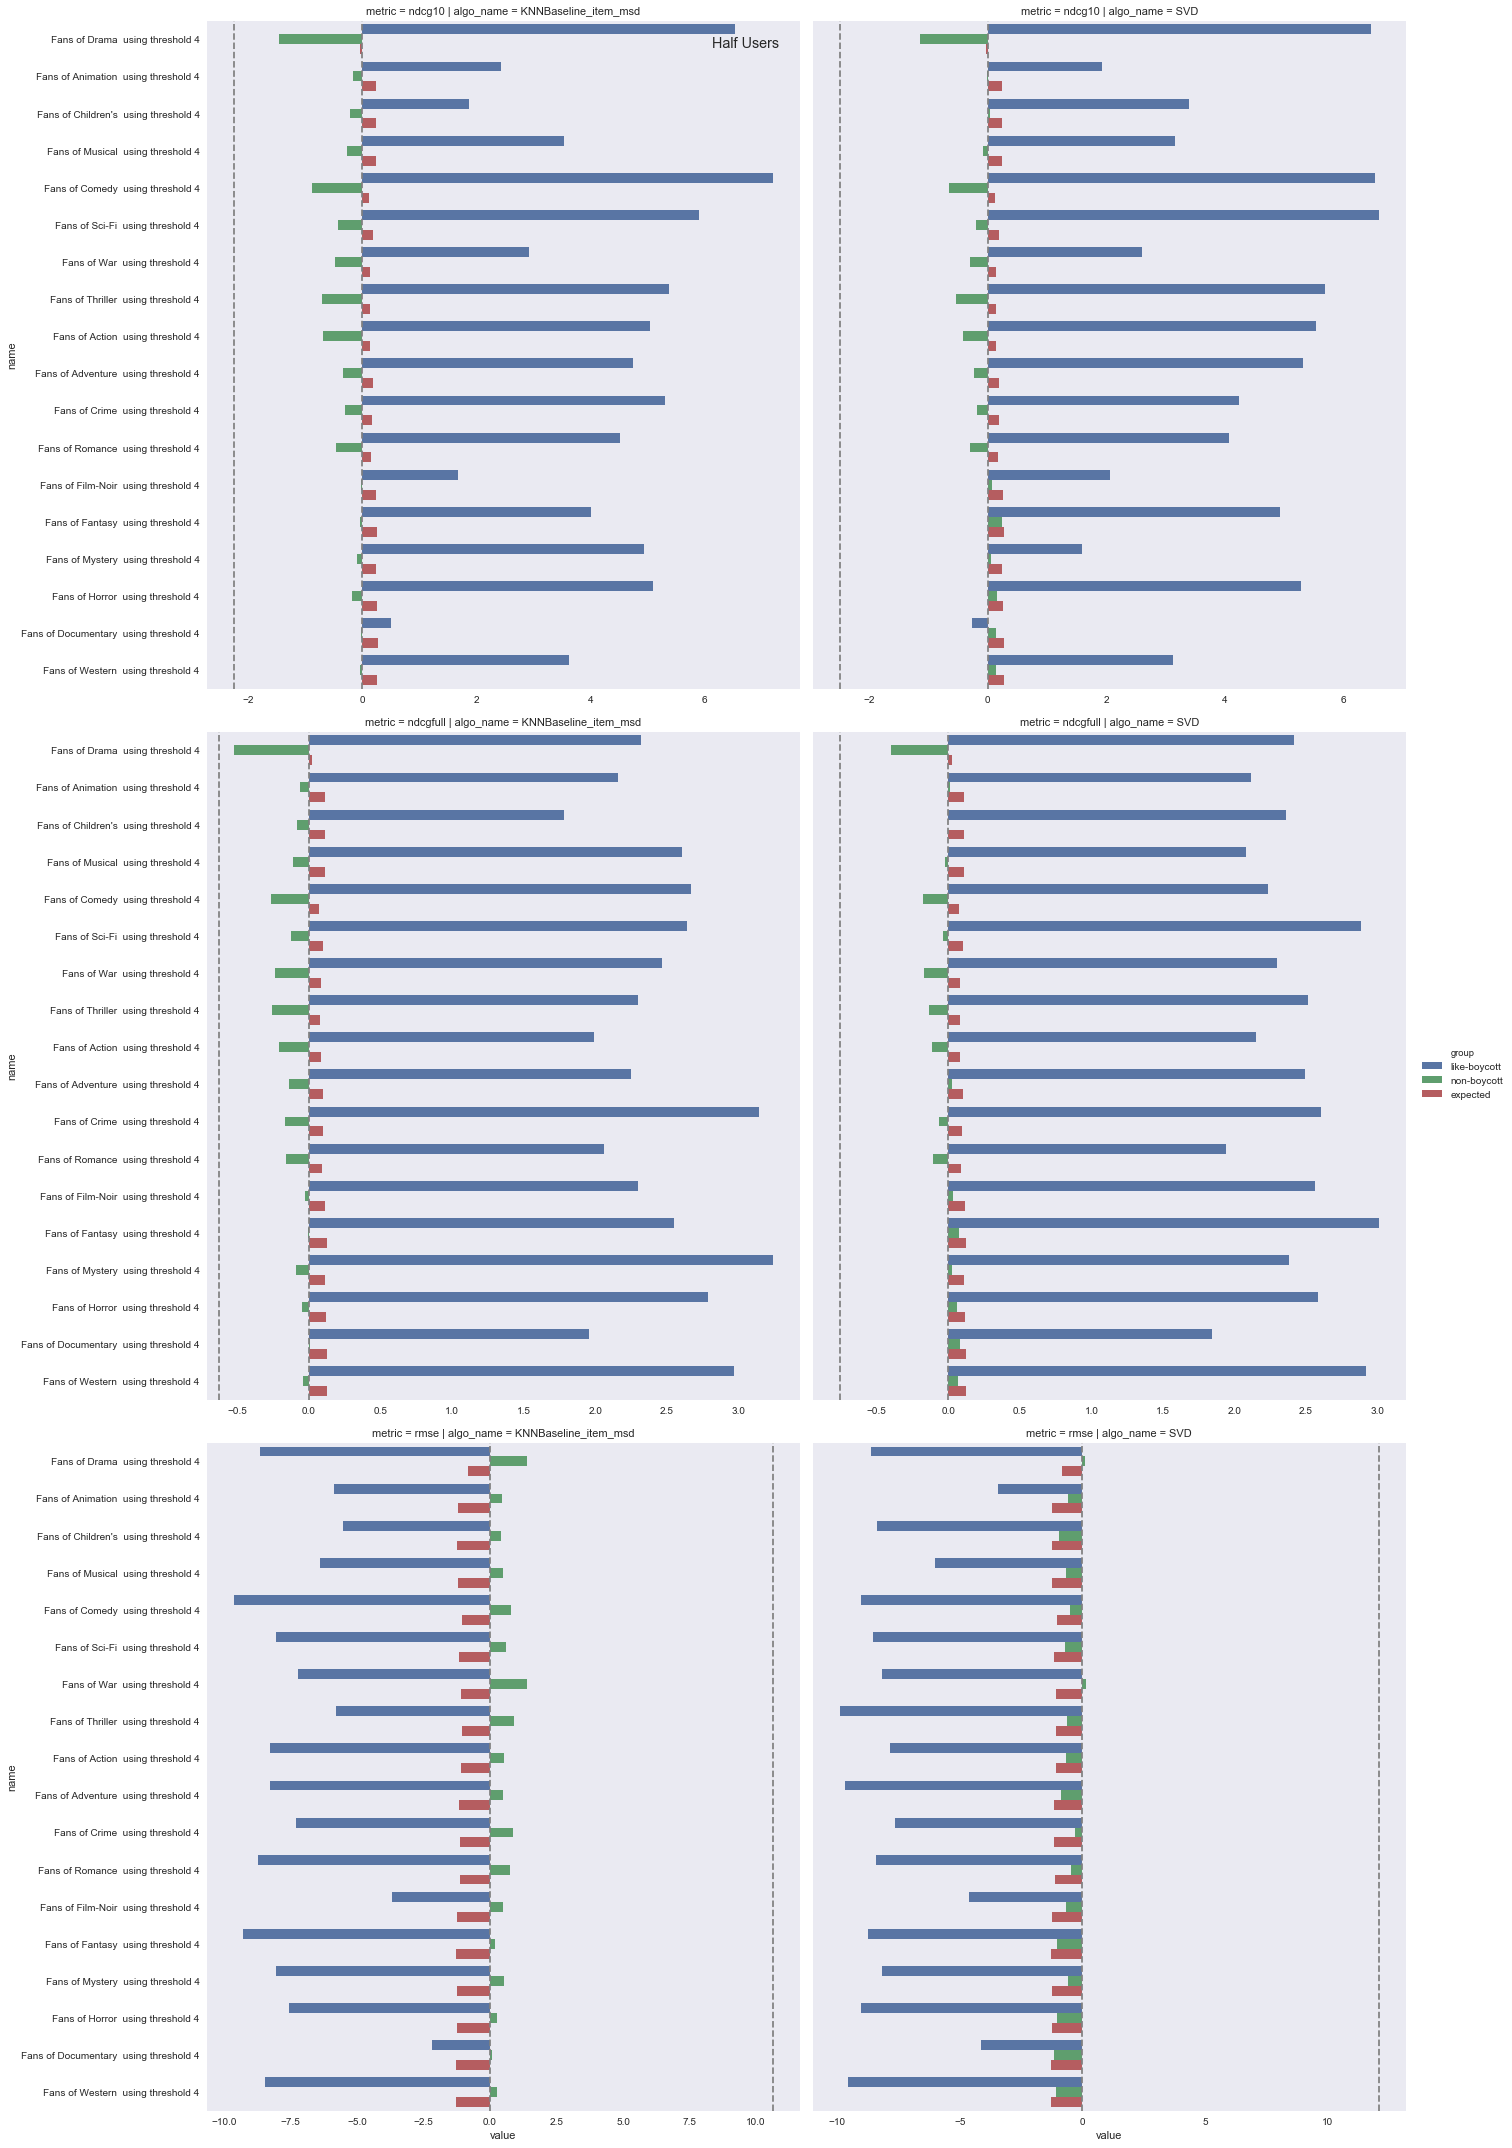

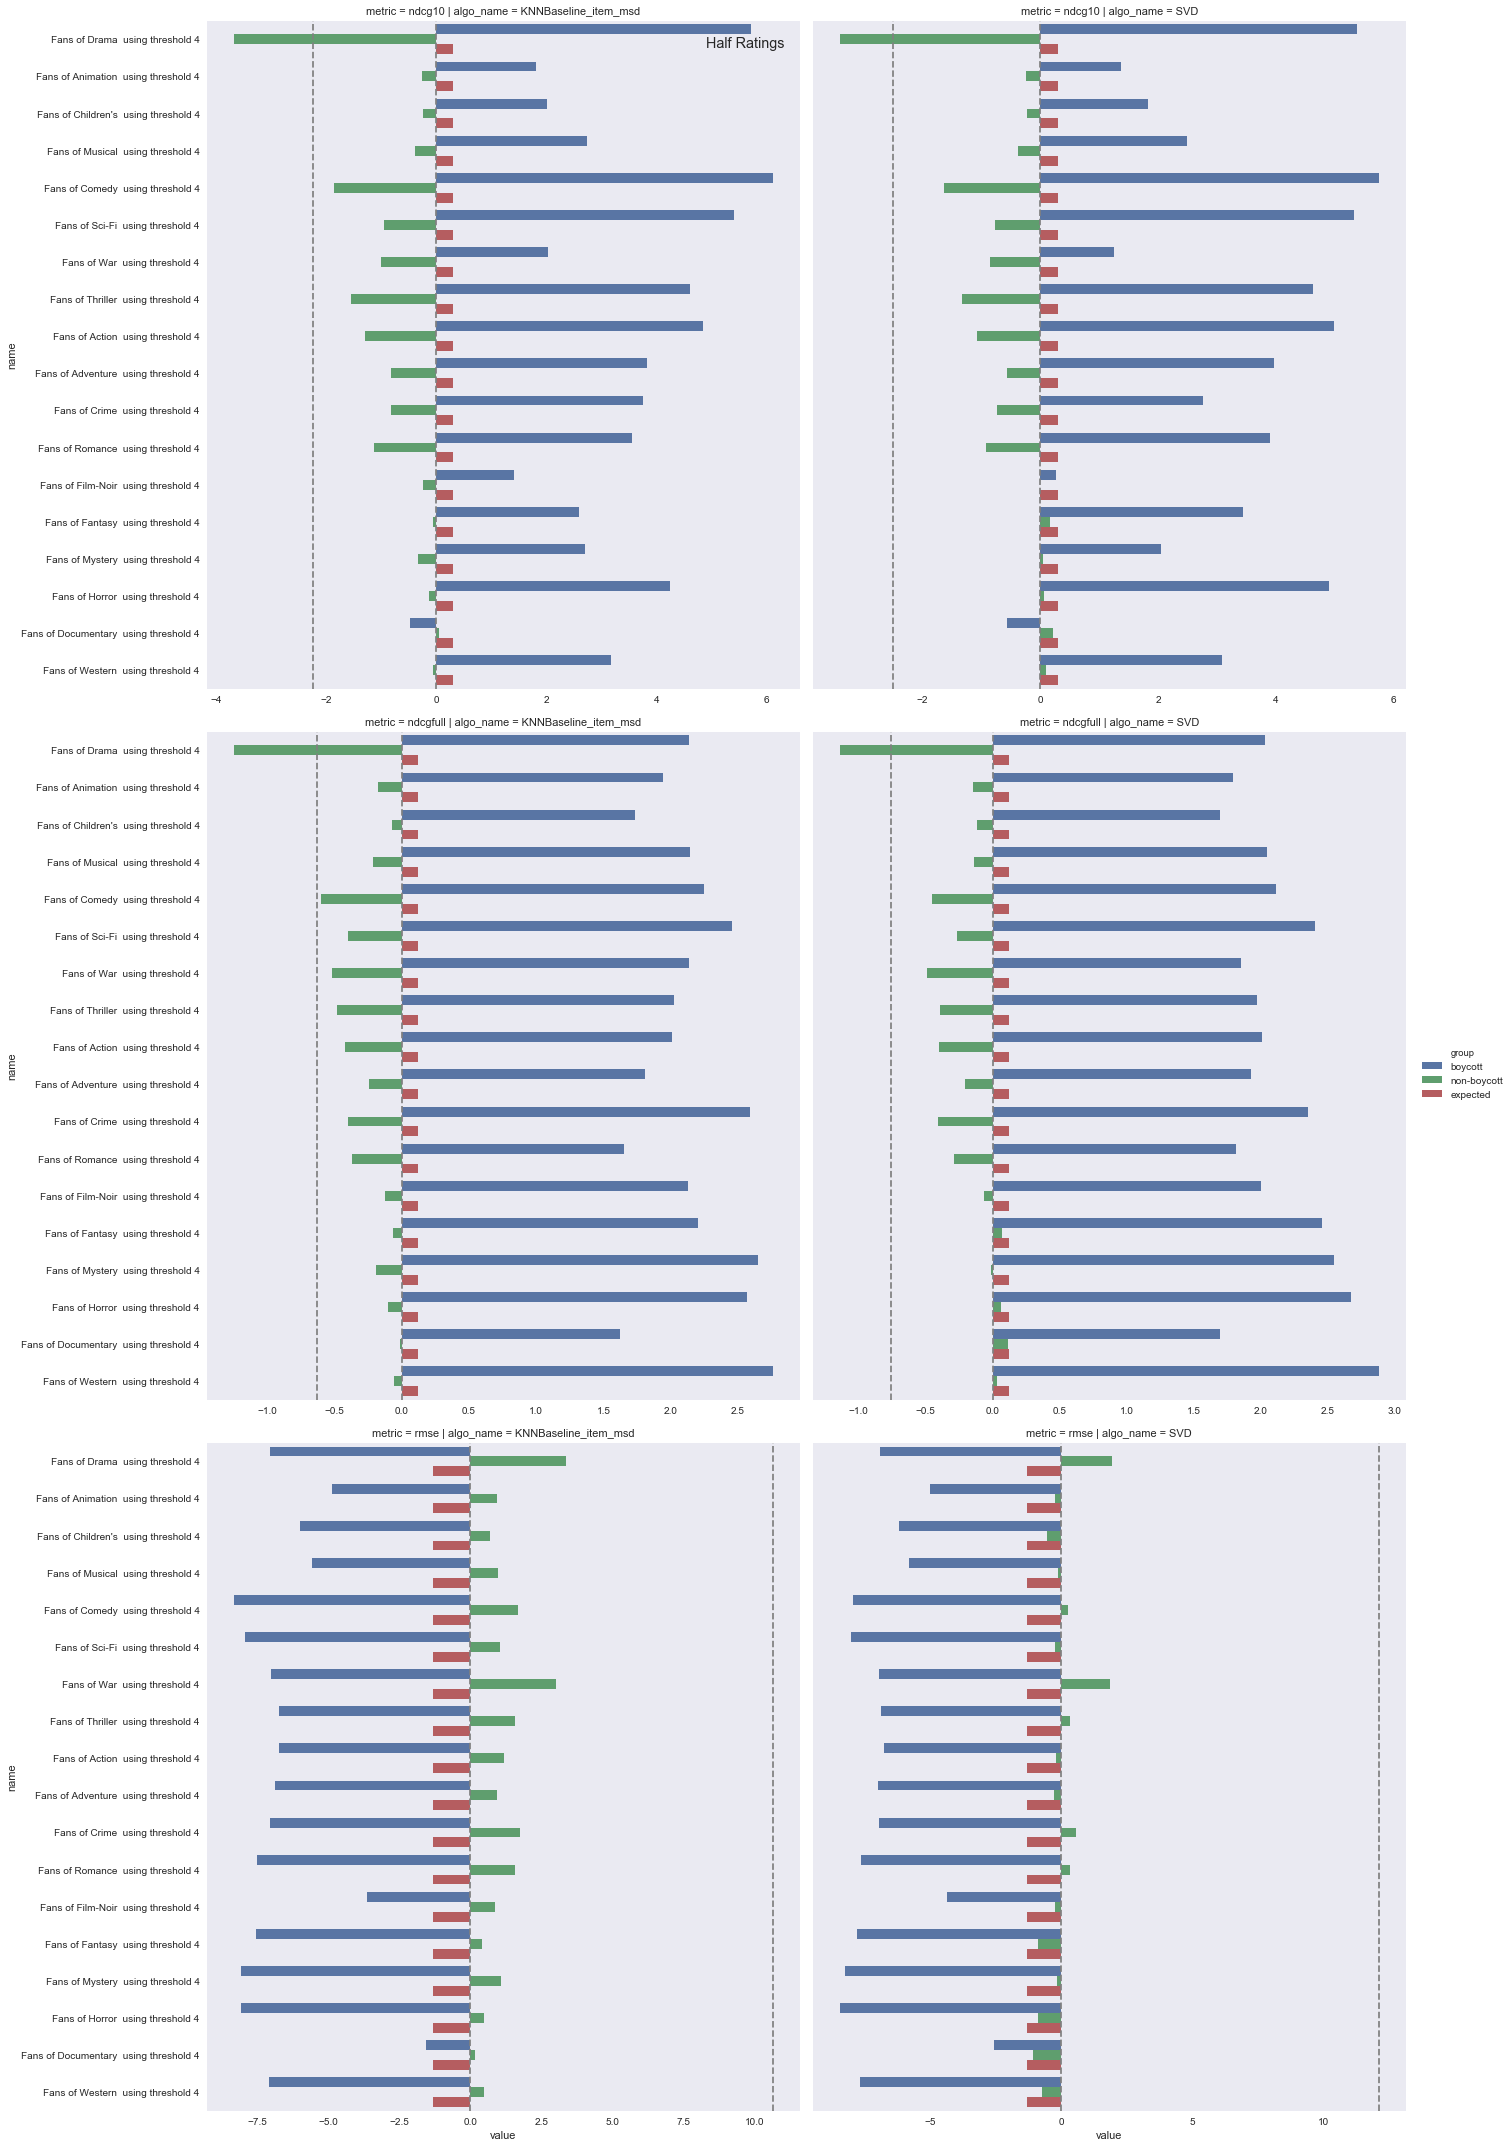

In [301]:
plot_all_three_scenarios(genre_boycotts, size=10)

# Notes
Gap between baseline and global means is less

Multiple reference points

What if nobody boycotted
What can users do relative to w/o a boycott

If enough users boycott, do algorithmic approaches become less meaningful

When does data stop being useful?

Effect can 

Central idea:

Value of the Computer Scientist vs. the Value of Data

# How effective are data boycotts

As long you have enough data
Company maintains

# Todo

No alg